# Описание проекта

**Заказчик:** Интернет-магазин «В один клик».

**Цель:** Разработка системы персонализированных предложений для удержания постоянных клиентов и увеличения их покупательской активности.

**Задачи:**

1. Анализ и предобработка данных о клиентах.
2. Разработка модели бинарной классификации для прогнозирования вероятности снижения покупательской активности клиента.
3. Сегментация клиентов на основе прогнозов модели и данных о прибыльности.
4. Разработка персонализированных предложений для целевых сегментов клиентов.

**Источник данных:**

- market_file.csv (основные данные о поведении и характеристиках клиентов)
- market_money.csv (данные о выручке по временным периодам)
- market_time.csv (данные о времени на сайте по временным периодам)
- money.csv (данные о прибыльности клиентов за последние 3 месяца)

Импортируем используемые библиотеки и фиксируем константы:

In [1]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import shapiro
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin

import shap

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TEST_SIZE = 0.25

/opt/homebrew/Cellar/jupyterlab/4.5.2/libexec/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Шаг 1. Загрузка данных

1.1 Загрузим данные в датафреймы pandas

In [4]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',')

In [5]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')

In [6]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')

In [7]:
try:
    money = pd.read_csv('/datasets/money.csv', sep=';')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

1.2 Проверим, что данные в таблицах соответствуют описанию

1.2.1 market_file

а. Выведим первые строки датафрейма и изучим общую информацию:

In [8]:
market_file.head(3)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [9]:
market_file.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   str    
 2   Тип сервиса                          1300 non-null   str    
 3   Разрешить сообщать                   1300 non-null   str    
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   str    
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                       1300

**Комментарий касательно market_file:**
- всего 1300 наблюдений,
- отсутствуют явные пропуски,
- названия столбцов не приведены к стандартному представлению (лучше использовать snake_case).

б. Исправим выеявленные недочеты в market_file:

- Приведем название столбцов в snake_case

In [10]:
market_file.columns = [re.sub(r'(?<!^)(?=[A-ZА-Я])', '_', i).replace(' ', '_').lower() for i in market_file.columns]

Проверим результаты корректировки данных в market_file:

In [11]:
market_file.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   str    
 2   тип_сервиса                          1300 non-null   str    
 3   разрешить_сообщать                   1300 non-null   str    
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   str    
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                       1300

**Комментарий:** Недочеты в market_file исправлены.

1.2.2 market_money

а. Выведим первые строки датафрейма и изучим общую информацию:

In [12]:
market_money.head(3)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [13]:
market_money.info()

<class 'pandas.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   str    
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), str(1)
memory usage: 91.5 KB


**Комментарий касательно market_money:**
- всего 3900 наблюдений,
- отсутствуют явные пропуски,
- названия столбцов не приведены к стандартному представлению (лучше использовать строчные буквы).

б. Исправим выеявленные недочеты в market_money:

- Заменим заглавную букву на строчную в названиях столбцов

In [14]:
market_money.columns = [i.lower() for i in market_money.columns]

Проверим результаты корректировки данных в market_money:

In [15]:
market_money.info()

<class 'pandas.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   str    
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), str(1)
memory usage: 91.5 KB


**Комментарий:** Недочеты в market_money исправлены.

1.2.3 market_time

а. Выведим первые строки датафрейма и изучим общую информацию:

In [16]:
market_time.head(3)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [17]:
market_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2600 non-null   int64
 1   Период  2600 non-null   str  
 2   минут   2600 non-null   int64
dtypes: int64(2), str(1)
memory usage: 61.1 KB


**Комментарий касательно market_time:**
- всего 2600 наблюдений,
- отсутствуют явные пропуски,
- названия столбцов не приведены к стандартному представлению (лучше использовать строчные буквы).

б. Исправим выеявленные недочеты в market_time:

- Заменим заглавную букву на строчную в названиях столбцов

In [18]:
market_time.columns = [i.lower() for i in market_time.columns]

Проверим результаты корректировки данных в market_time:

In [19]:
market_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2600 non-null   int64
 1   период  2600 non-null   str  
 2   минут   2600 non-null   int64
dtypes: int64(2), str(1)
memory usage: 61.1 KB


**Комментарий:** Недочеты в market_time исправлены.

1.2.4 money

а. Выведим первые строки датафрейма и изучим общую информацию:

In [20]:
money.head(3)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"


In [21]:
money.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       1300 non-null   int64
 1   Прибыль  1300 non-null   str  
dtypes: int64(1), str(1)
memory usage: 20.4 KB


**Комментарий касательно money:**
- всего 1300 наблюдений,
- отсутствуют явные пропуски,
- названия столбцов не приведены к стандартному представлению (лучше использовать строчные буквы),
- дробные числа используют запятую как разделитель,
- в столбце Прибыль, необходимо изменить тип данных на числовой.

б. Исправим выеявленные недочеты в money:

- Заменим заглавную букву на строчную в названиях столбцов

In [22]:
money.columns = [i.lower() for i in money.columns]

- Заменим разделитель на точку в дробных числах и измененим тип данных на числовой

In [23]:
money['прибыль'] = money['прибыль'].str.replace(',', '.').astype('float')

Проверим результаты корректировки данных в market_file:

In [24]:
money.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


In [25]:
money.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Комментарий:** Недочеты в money исправлены.

**Выводы по Шагу 1:**

Успешно выполнено:

1. Все файлы загружены корректно с учетом особенностей формата:

- market_file.csv, market_money.csv, market_time.csv - разделитель запятая
- money.csv - разделитель точка с запятой, десятичный разделитель запятая

2. Проведена первичная проверка соответствия данных описанию:

- market_file: 1300 наблюдений, 13 столбцов (целевой признак + 12 признаков-предикторов)
- market_money: 3900 наблюдений (по 3 периода на каждого клиента)
- market_time: 2600 наблюдений (по 2 периода на каждого клиента)
- money: 1300 наблюдений (прибыль по каждому клиенту)

3. Выполнена стандартизация названий столбцов:

- Приведены к нижнему регистру
- Для market_file применен snake_case для лучшей читаемости

4. Исправлены проблемы с типами данных:

- В таблице money столбец "прибыль" преобразован из строкового в числовой формат (float)

Обнаруженные особенности данных:

- Полнота данных: Пропуски отсутствуют во всех таблицах
- Согласованность: Все таблицы содержат одинаковое количество клиентов (1300)
- Временные периоды: Данные о выручке и времени охватывают разные временные интервалы

Готовность к следующим этапам:

- Данные успешно загружены, проверены и подготовлены для перехода к Шагу 2: Предобработка данных и последующему исследовательскому анализу.


# Шаг 2. Предобработка данных

- Выше было выявлено, что пропуски в данных отсутствуют.
- Названия столбцов приведены в snake_case.
- Тип данных в одном столбце был изменен на числовой (дробный).

Проверим на наличие явных и неявных дубликатов:

2.1 market_file

а. Повторно проанализируем market_file

In [26]:
market_file.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [27]:
market_file.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   str    
 2   тип_сервиса                          1300 non-null   str    
 3   разрешить_сообщать                   1300 non-null   str    
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   str    
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                       1300

б. Проверим дубликаты в отдельных столбцах

- столбец id

In [28]:
duplicates = market_file[market_file.duplicated(subset='id', keep=False)]
duplicates = duplicates.sort_values(by='id')
duplicates

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


**Комментарий:** В столбце "id" дубликаты отсутствуют.

- столбец покупательская_активность

In [29]:
market_file['покупательская_активность'].unique()

<StringArray>
['Снизилась', 'Прежний уровень']
Length: 2, dtype: str

**Комментарий:** Имеются два уникальных значения показателя покупательская_активность. Неявных дубликатов не выявлено. Однако для универсальности изменим уникальные значения (уберем заглавные буквы и пробел заменим на нижний прочерк).

Заменим значения:

In [30]:
market_file['покупательская_активность'] = (
    market_file['покупательская_активность']
    .str.lower()
    .str.replace(' ', '_')
)
market_file['покупательская_активность'].unique()

<StringArray>
['снизилась', 'прежний_уровень']
Length: 2, dtype: str

- столбец тип_сервиса

In [31]:
market_file['тип_сервиса'].unique()

<StringArray>
['премиум', 'стандартт', 'стандарт']
Length: 3, dtype: str

**Комментарий:** стандартт и стандарт являются неявными дубликатами.

Заменим значения:

In [32]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

<StringArray>
['премиум', 'стандарт']
Length: 2, dtype: str

**Комментарий:** В анализируемом столбце неявные дубликаты устранены.

- столбец разрешить_сообщать

In [33]:
market_file['разрешить_сообщать'].unique()

<StringArray>
['да', 'нет']
Length: 2, dtype: str

**Комментарий:** Имеются два уникальных значения показателя разрешить_сообщать. Неявных дубликатов не выявлено. 

- столбец популярная_категория

In [34]:
market_file['популярная_категория'].unique()

<StringArray>
[                    'Товары для детей',
                    'Домашний текстиль',
                'Косметика и аксесуары',
       'Техника для красоты и здоровья',
                      'Кухонная посуда',
 'Мелкая бытовая техника и электроника']
Length: 6, dtype: str

**Комментарий:** Имеются 6 уникальных значений показателя популярная_категория. Неявных дубликатов не выявлено. Однако для универсальности изменим уникальные значения (уберем заглавные буквы и пробел заменим на нижний прочерк).

Заменим значения:

In [35]:
market_file['популярная_категория'] = (
    market_file['популярная_категория']
    .str.lower()
    .str.replace(' ', '_')
)
market_file['популярная_категория'].unique()

<StringArray>
[                    'товары_для_детей',
                    'домашний_текстиль',
                'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья',
                      'кухонная_посуда',
 'мелкая_бытовая_техника_и_электроника']
Length: 6, dtype: str

в. Проверим полные дубликаты строк

In [36]:
print('Полные дубликаты:', market_file.duplicated().sum())

Полные дубликаты: 0


**Комментарий:** Полные дубликаты отсутствуют.

2.2 market_money

а. Повторно проанализируем market_money

In [37]:
market_money.head(3)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [38]:
market_money.info()

<class 'pandas.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   str    
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), str(1)
memory usage: 91.5 KB


б. Проверим дубликаты в отдельных столбцах

- столбец id

In [39]:
duplicates = market_money[market_money.duplicated(subset='id', keep=False)]
duplicates = duplicates.sort_values(by='id')
duplicates

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3894,216646,текущий_месяц,5224.6
3896,216646,предыдущий_месяц,4923.0
3898,216647,препредыдущий_месяц,5183.0
3897,216647,предыдущий_месяц,4720.0


**Комментарий:** В столбце "id" имеются дубликаты, но их устранять не нужно т.к. в датафрейме хранится выручка по каждому клиенту за три отдельных месяца.

- столбец период

In [40]:
market_money['период'].unique()

<StringArray>
['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц']
Length: 3, dtype: str

**Комментарий:** Имеются 3 уникальных значения показателя период. Неявных дубликатов не выявлено.

в. Проверим полные дубликаты строк

In [41]:
print('Полные дубликаты:', market_money.duplicated().sum())

Полные дубликаты: 0


**Комментарий:** Полные дубликаты отсутствуют.

2.3 market_time

а. Повторно проанализируем market_time

In [42]:
market_time.head(3)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [43]:
market_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2600 non-null   int64
 1   период  2600 non-null   str  
 2   минут   2600 non-null   int64
dtypes: int64(2), str(1)
memory usage: 61.1 KB


б. Проверим дубликаты в отдельных столбцах

- столбец id

In [44]:
duplicates = market_time[market_time.duplicated(subset='id', keep=False)]
duplicates = duplicates.sort_values(by='id')
duplicates

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


**Комментарий:** В столбце "id" имеются дубликаты, но их устранять не нужно т.к. в датафрейме хранится информация о времени, которое покупатель провёл на сайте за два отдельных месяца.

- столбец период

In [45]:
market_time['период'].unique()

<StringArray>
['текущий_месяц', 'предыдцщий_месяц']
Length: 2, dtype: str

**Комментарий:** Имеются 2 уникальных значения показателя период. Неявных дубликатов не выявлено. Однако исправим грамматическую ошибку в значении.

Заменим значения:

In [46]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

<StringArray>
['текущий_месяц', 'предыдущий_месяц']
Length: 2, dtype: str

**Комментарий:** Грамматическая ошибка в значении исправлена.

в. Проверим полные дубликаты строк

In [47]:
print('Полные дубликаты:', market_time.duplicated().sum())

Полные дубликаты: 0


**Комментарий:** Полные дубликаты отсутствуют.

2.4 money

а. Повторно проанализируем money

In [48]:
money.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


In [49]:
money.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


в. Проверим полные дубликаты строк

In [50]:
print('Полные дубликаты:', money.duplicated().sum())

Полные дубликаты: 0


**Комментарий:** Полные дубликаты отсутствуют.

**Выводы по Шагу 2:**

Основные выполненные задачи:

1. Обработка категориальных переменных в market_file:

- Покупательская активность:

    - Унифицированы значения: снизилась, прежний_уровень
    - Убраны пробелы и приведены к нижнему регистру
    

- Тип сервиса: Исправлена опечатка стандартт - стандарт

    - Теперь два корректных значения: премиум, стандарт
    

- Популярная категория: Приведены к единому формату (нижний регистр, подчеркивания)

    - Сохранены все 6 оригинальных категорий товаров
        

2. Исправление ошибок в market_time:

- Периоды: Исправлена грамматическая ошибка предыдцщий_месяц - предыдущий_месяц

    - Теперь корректные значения: текущий_месяц, предыдущий_месяц


3. Проверка на дубликаты:

- Полные дубликаты строк: Отсутствуют во всех таблицах

- Дубликаты ID:

    - В market_file и money - уникальные ID клиентов
    - В market_money и market_time - дубликаты ID ожидаемы (разные периоды для одного клиента)

Готовность к следующим этапам:

- Данные полностью подготовлены для перехода к Шагу 3: Исследовательский анализ данных. Все выявленные проблемы решены:

    - Исправлены опечатки в категориальных значениях
    - Унифицированы форматы строковых данных
    - Подтверждена целостность данных
    - Обеспечена согласованность между таблицами

Рекомендация для следующего шага:
- При исследовательском анализе обратить внимание на распределение целевой переменной и проверить клиентов с нулевой выручкой для фильтрации неактивных пользователей.

# Шаг 3. Исследовательский анализ данных

3.1 market_file

In [51]:
market_file.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   str    
 2   тип_сервиса                          1300 non-null   str    
 3   разрешить_сообщать                   1300 non-null   str    
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   str    
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                       1300

- качественный показатель покупательская_активность

Анализ уникальных значений:

In [52]:
market_file['покупательская_активность'].value_counts()

покупательская_активность
прежний_уровень    802
снизилась          498
Name: count, dtype: int64

In [53]:
def plot_pie_chart(data, column, title, colors=['blue', 'green'], figsize=(6, 4)):
    graph_data = data[column].value_counts()
    
    # Создаем круговую диаграмму
    plt.figure(figsize=figsize)
    wedges, texts, autotexts = plt.pie(graph_data.values,
                                       labels=graph_data.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90,
                                       textprops={'fontsize': 12})
    
    # Настраиваем внешний вид процентов
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.title(title)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

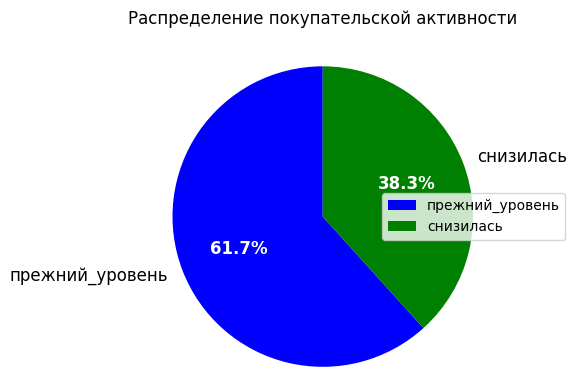

In [54]:
plot_pie_chart(market_file, 'покупательская_активность', 
               'Распределение покупательской активности\n')

**Комментарий:** Имеется дисбаланс в целевой переменной покупательская_активность: больше клиентов, имеющих прежний уровень покупательской активности (62%). Это нужно будет учесть при дальнейшем анализе и моделировании.

- качественный показатель тип_сервиса

Анализ уникальных значений:

In [55]:
market_file['тип_сервиса'].value_counts()

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

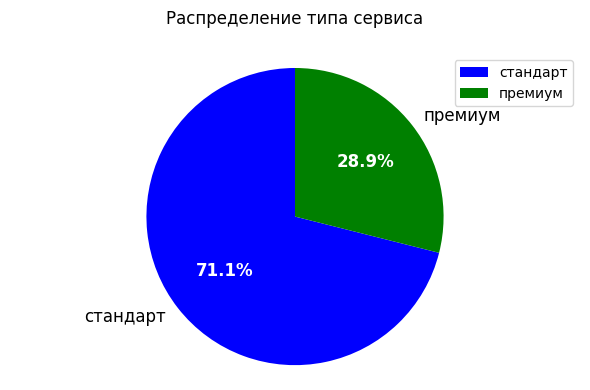

In [56]:
plot_pie_chart(market_file, 'тип_сервиса', 
               'Распределение типа сервиса\n')

**Комментарий:** В выборке больше клиентов с типом сервиса "стандарт" (71%).

- качественный показатель разрешить_сообщать

Анализ уникальных значений:

In [57]:
market_file['разрешить_сообщать'].value_counts()

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

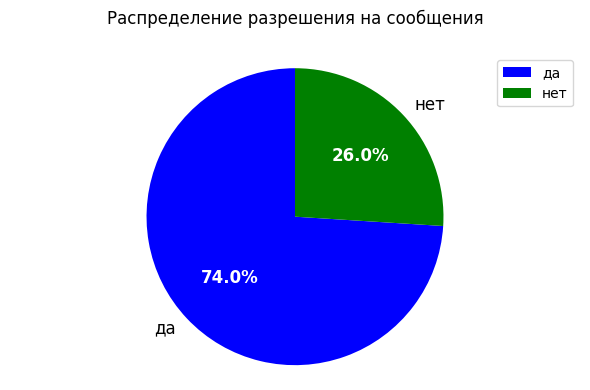

In [58]:
plot_pie_chart(market_file, 'разрешить_сообщать', 
               'Распределение разрешения на сообщения\n')

**Комментарий:** В выборке больше клиентов, которые дали согласие на рассылку дополнительных предложений о товаре (74%).

- количественный показатель маркет_актив 6 мес

In [59]:
market_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

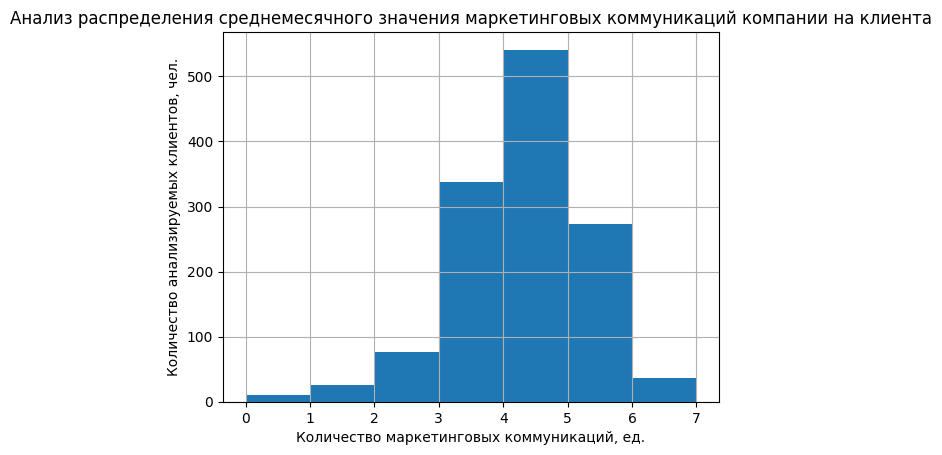

In [60]:
market_file['маркет_актив_6_мес'].hist(bins=7, range=(0,7))
plt.title('Анализ распределения среднемесячного значения маркетинговых коммуникаций компании на клиента')
plt.xlabel('Количество маркетинговых коммуникаций, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [61]:
stat, p_value = shapiro(market_file['маркет_актив_6_мес'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9780, p-value=0.000
Не нормальное распределение (отвергаем H0)


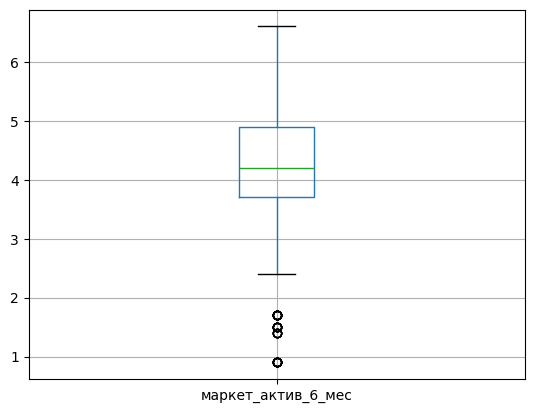

In [62]:
market_file.boxplot(column='маркет_актив_6_мес');

**Комментарий:** Распределение показателя имеет слабовыраженную левую асимметрию со средним значением 4,25 коммуникаций на клиента. Гистограмма и тест Шапиро-Уилка (p-value = 0,00) однозначно указывают на отклонение от нормального распределения. Разброс значений относительно невелик (std = 1,01), что свидетельствует о достаточно однородной стратегии коммуникаций с клиентами. Боксплот показывает на незначительное количество выбросов со со значениями меньше 2, а межквартильный размах сосредоточен в диапазоне 3,7-4,9 коммуникаций, что указывает на стабильность маркетинговой политики.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Очень детальная описательная статистика количественных переменных 👍 Отдельно молодец, что используешь критерий Шапиро-Уилка для оценки нормальности распределения выборки!
</div>

- количественный показатель маркет_актив_тек_мес

In [63]:
market_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

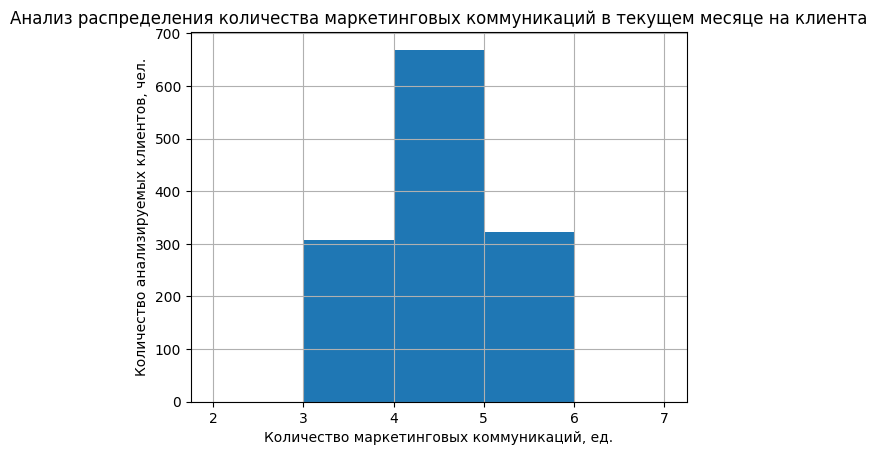

In [64]:
market_file['маркет_актив_тек_мес'].hist(bins=5, range=(2,7))
plt.title('Анализ распределения количества маркетинговых коммуникаций в текущем месяце на клиента')
plt.xlabel('Количество маркетинговых коммуникаций, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [65]:
stat, p_value = shapiro(market_file['маркет_актив_тек_мес'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.8060, p-value=0.000
Не нормальное распределение (отвергаем H0)


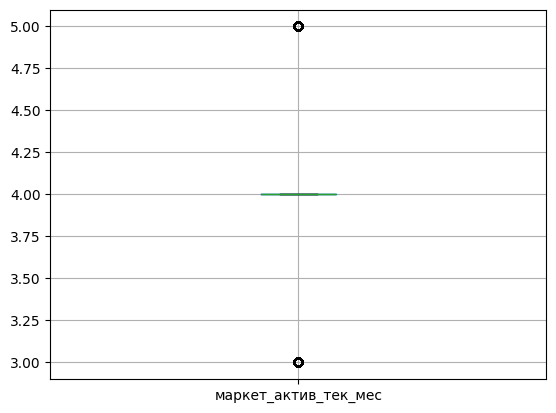

In [66]:
market_file.boxplot(column='маркет_актив_тек_мес');

**Комментарий:** На основе анализа распределения маркетинговой активности в текущем месяце наблюдаем высокую стандартизацию коммуникационной политики. Показатель демонстрирует крайне низкую вариативность (std = 0,7) с концентрацией 75% клиентов на уровне ровно 4 коммуникаций. Распределение является дискретным, что подтверждается низким значением статистики Шапиро-Уилка (0.806) и нулевым p-value. Ограниченный диапазон значений от 3 до 5 единиц свидетельствует о строгом регламентировании маркетинговых воздействий в текущем периоде. Такая картина распределения указывает на применение шаблонного подхода в коммуникациях с клиентами.

- количественный показатель длительность

In [67]:
market_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

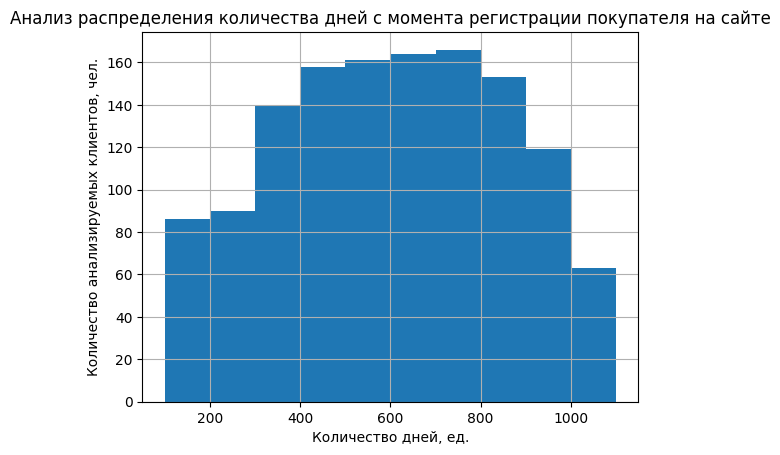

In [68]:
market_file['длительность'].hist(bins=10, range=(100,1100))
plt.title('Анализ распределения количества дней с момента регистрации покупателя на сайте')
plt.xlabel('Количество дней, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [69]:
stat, p_value = shapiro(market_file['длительность'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9727, p-value=0.000
Не нормальное распределение (отвергаем H0)


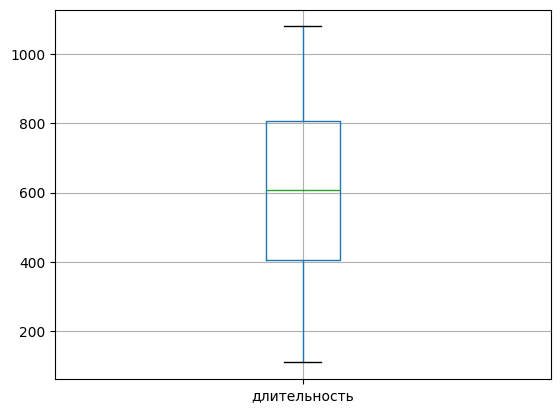

In [70]:
market_file.boxplot(column='длительность');

**Комментарий:** Анализ количества дней с момента регистрации покупателя на сайте показал близкое к равномерному  распределению по диапазону от 110 до 1079 дней. Среднее значение 602 дня при медиане 606 дней свидетельствует о симметричности распределения без выраженного перекоса. Тест Шапиро-Уилка (p-value = 0,00) подтведил отклонение от нормального распределения. Боксплот показывает отсутствие выбросов. Распределение демонстрирует клиентскую базу с хорошим балансом между новыми и давними клиентами.

- количественный показатель акционные_покупки

In [71]:
market_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

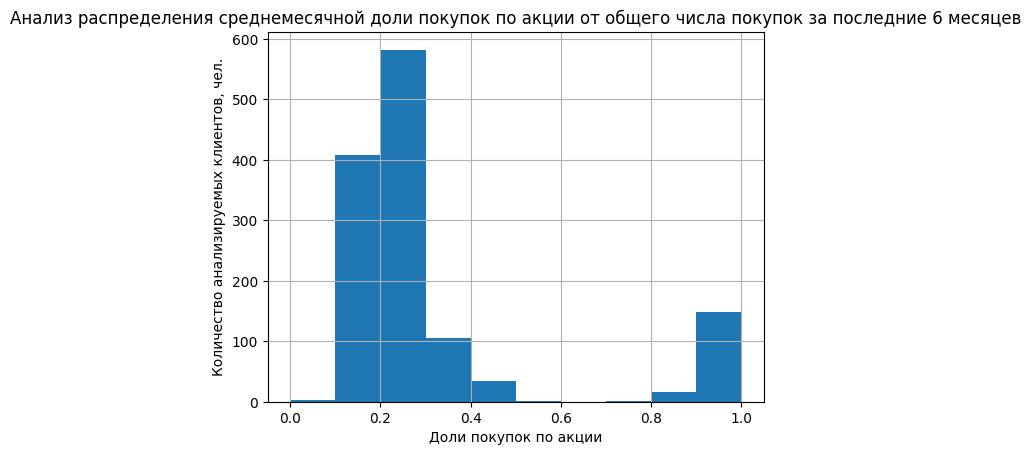

In [72]:
market_file['акционные_покупки'].hist(bins=10, range=(0,1))
plt.title('Анализ распределения среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев')
plt.xlabel('Доли покупок по акции')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [73]:
stat, p_value = shapiro(market_file['акционные_покупки'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.6621, p-value=0.000
Не нормальное распределение (отвергаем H0)


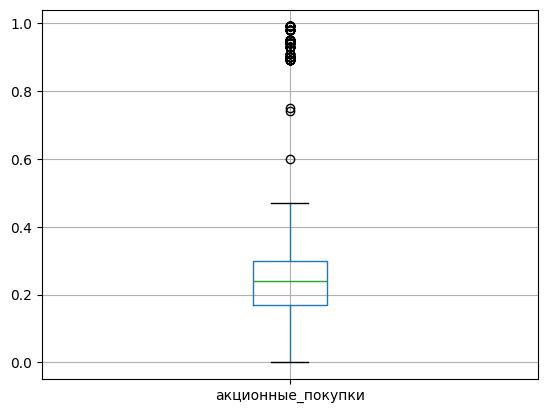

In [74]:
market_file.boxplot(column='акционные_покупки');

In [75]:
count_clients = len(market_file[market_file['акционные_покупки'] > 0.9])
print(f"Число клиентов с долей покупок по акции > 0.9: {count_clients}")

total_clients = len(market_file)
percentage = (count_clients / total_clients) * 100
print(f"Доля таких клиентов от общей базы: {percentage:.1f}%")

Число клиентов с долей покупок по акции > 0.9: 138
Доля таких клиентов от общей базы: 10.6%


**Комментарий:** Анализ распределения доли акционных покупок показывает выраженную правую асимметрию с концентрацией большинства клиентов в диапазоне низких значений. Медианное значение 0,24 значительно ниже среднего 0,32, что указывает на преобладание клиентов с умеренной чувствительностью к акциям. При этом выделяется существенная группа "акционных охотников" - 10,6% клиентов совершают более 90% покупок по акциям. Распределение имеет резкий пик в зоне 0,1-0,3 долей с последующим плавным спадом, что свидетельствует о поляризации клиентской базы по восприимчивости к акционным предложениям.

- качественный показатель популярная_категория

Анализ уникальных значений:

In [76]:
market_file['популярная_категория'].value_counts()

популярная_категория
товары_для_детей                        330
домашний_текстиль                       251
косметика_и_аксесуары                   223
техника_для_красоты_и_здоровья          184
мелкая_бытовая_техника_и_электроника    174
кухонная_посуда                         138
Name: count, dtype: int64

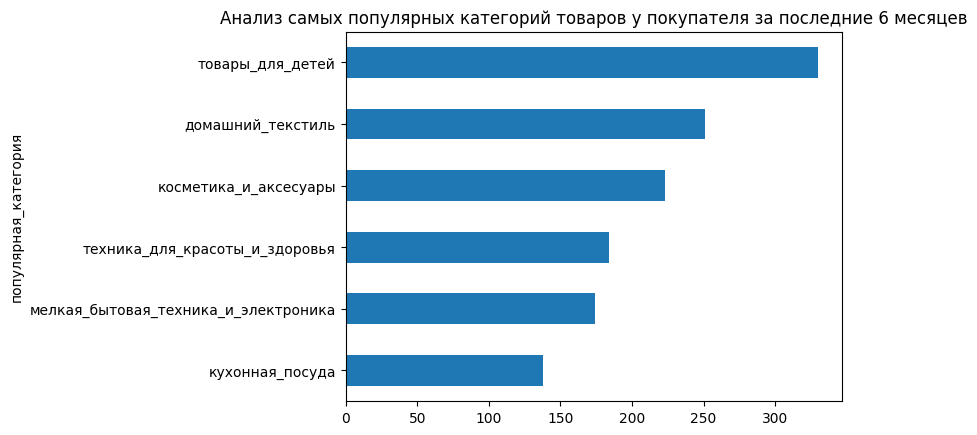

In [77]:
market_file['популярная_категория'].value_counts().sort_values().plot(kind='barh',title='Анализ самых популярных категорий товаров у покупателя за последние 6 месяцев');

**Комментарий:** Анализ популярных категорий товаров выявляет четкую иерархию потребительских предпочтений. Лидером является категория "товары для детей" с 330 клиентами, что составляет более 25% всей базы, что свидетельствует о высокой востребованности детских товаров. Наблюдается постепенное снижение популярности от детских товаров к кухонной посуде, которая занимает последнее место с 138 клиентами. Распределение категорий достаточно равномерное без резких перепадов.

- количественный показатель средний_просмотр_категорий_за_визит

In [78]:
market_file['средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

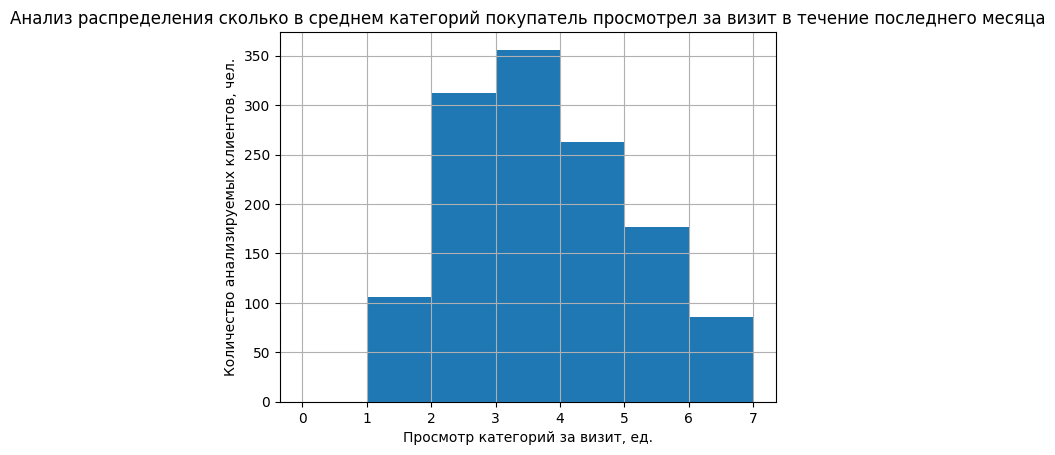

In [79]:
market_file['средний_просмотр_категорий_за_визит'].hist(bins=7, range=(0,7))
plt.title('Анализ распределения сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца')
plt.xlabel('Просмотр категорий за визит, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [80]:
stat, p_value = shapiro(market_file['средний_просмотр_категорий_за_визит'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9306, p-value=0.000
Не нормальное распределение (отвергаем H0)


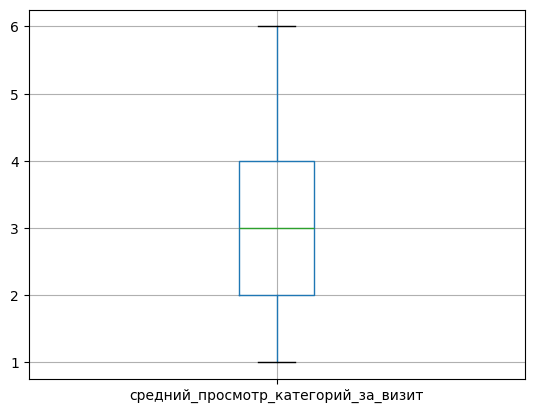

In [81]:
market_file.boxplot(column='средний_просмотр_категорий_за_визит');

**Комментарий:** Анализ поведения клиентов при просмотре категорий показывает умеренную активность с медианным значением 3 категории за визит. Распределение имеет слабовыраженную правую асимметрию с пиком на 3 категориях, где сконцентрировано наибольшее число клиентов. Стандартное отклонение 1,36 указывает на умеренный разброс поведения - большинство клиентов просматривают от 2 до 4 категорий за визит.

- количественный показатель неоплаченные_продукты_штук_квартал

In [82]:
market_file['неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

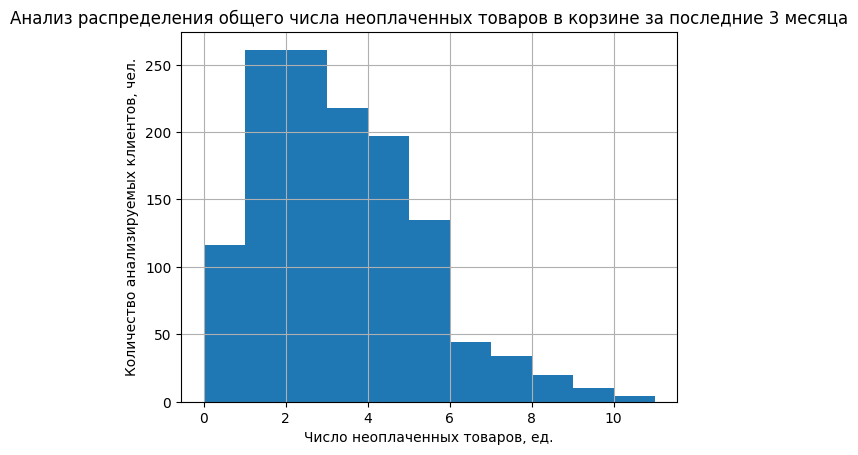

In [83]:
market_file['неоплаченные_продукты_штук_квартал'].hist(bins=11, range=(0,11))
plt.title('Анализ распределения общего числа неоплаченных товаров в корзине за последние 3 месяца')
plt.xlabel('Число неоплаченных товаров, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [84]:
stat, p_value = shapiro(market_file['неоплаченные_продукты_штук_квартал'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9329, p-value=0.000
Не нормальное распределение (отвергаем H0)


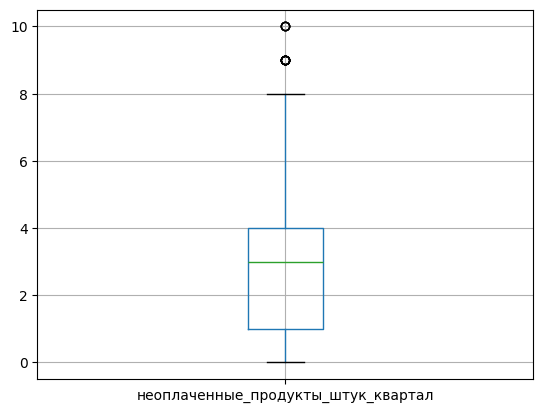

In [85]:
market_file.boxplot(column='неоплаченные_продукты_штук_квартал');

**Комментарий:** Анализ неоплаченных товаров в корзинах клиентов показывает выраженную правую асимметрию распределения с медианой 3 товара при среднем значении 2,8. Наибольшая концентрация клиентов наблюдается в диапазоне 1-4 неоплаченных товара, что свидетельствует о типичном поведении "отложенных покупок". При этом наличие клиентов с 9-10 неоплаченными товарами указывает на существование сегмента с проблемным покупательским поведением.

- количественный показатель ошибка_сервиса

In [86]:
market_file['ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

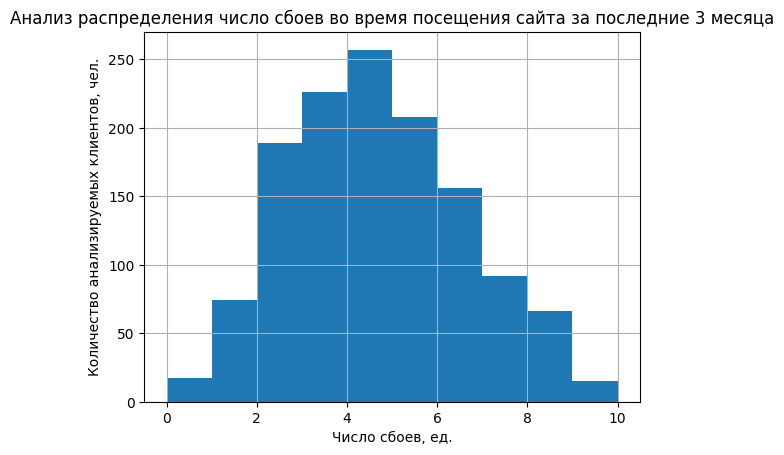

In [87]:
market_file['ошибка_сервиса'].hist(bins=10, range=(0,10))
plt.title('Анализ распределения число сбоев во время посещения сайта за последние 3 месяца')
plt.xlabel('Число сбоев, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [88]:
stat, p_value = shapiro(market_file['ошибка_сервиса'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9659, p-value=0.000
Не нормальное распределение (отвергаем H0)


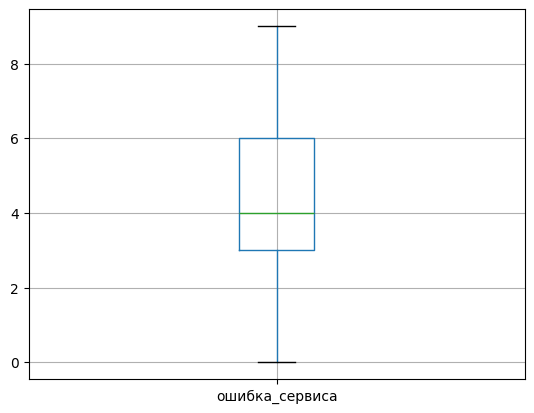

In [89]:
market_file.boxplot(column='ошибка_сервиса');

**Комментарий:** Анализ технических сбоев сервиса демонстрирует умеренно высокий уровень проблем с медианой 4 сбоя за 3 месяца. Распределение в целом симметрично с концентрацией большинства клиентов в диапазоне 3-6 сбоев. Стандартное отклонение 2,0 указывает на существенный разброс в опыте пользователей - от полного отсутствия сбоев до 9 инцидентов за квартал. Распределение показывает, что технические сбои затрагивают практически всю клиентскую базу, но с различной интенсивностью.

- количественный показатель страниц_за_визит

In [90]:
market_file['страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

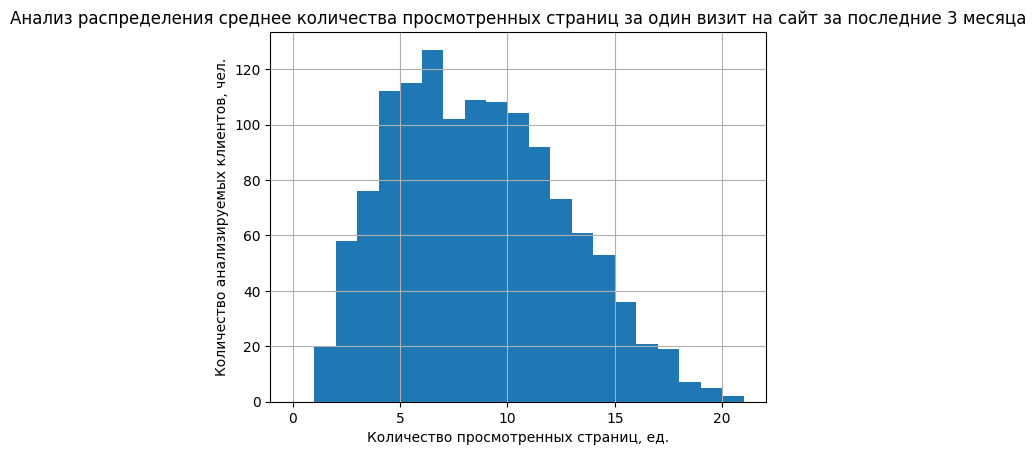

In [91]:
market_file['страниц_за_визит'].hist(bins=21, range=(0,21))
plt.title('Анализ распределения среднее количества просмотренных страниц за один визит на сайт за последние 3 месяца')
plt.xlabel('Количество просмотренных страниц, ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [92]:
stat, p_value = shapiro(market_file['страниц_за_визит'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9738, p-value=0.000
Не нормальное распределение (отвергаем H0)


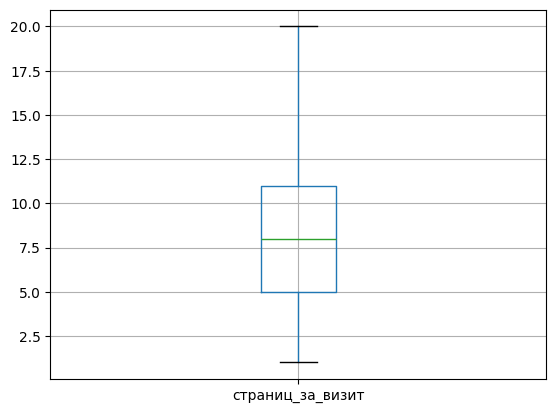

In [93]:
market_file.boxplot(column='страниц_за_визит');

**Комментарий:** Анализ глубины просмотра сайта показывает широкий разброс поведения клиентов со средним значением 8,2 страницы за визит. Значительное стандартное отклонение (4,0) подтверждает высокую вариативность вовлеченности клиентов - от поверхностного ознакомления (1 страница) до детального изучения ассортимента (20 страниц). Межквартильный размах 5-11 страниц охватывает основную массу клиентов, при этом каждый четвертый пользователь проявляет высокую активность, просматривая более 11 страниц за визит. Такое распределение свидетельствует о необходимости персонализации пользовательского опыта для разных сегментов аудитории.

3.2 market_money

In [94]:
market_money.info()

<class 'pandas.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   str    
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), str(1)
memory usage: 91.5 KB


- качественный показатель период

Анализ уникальных значений:

In [95]:
market_money['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

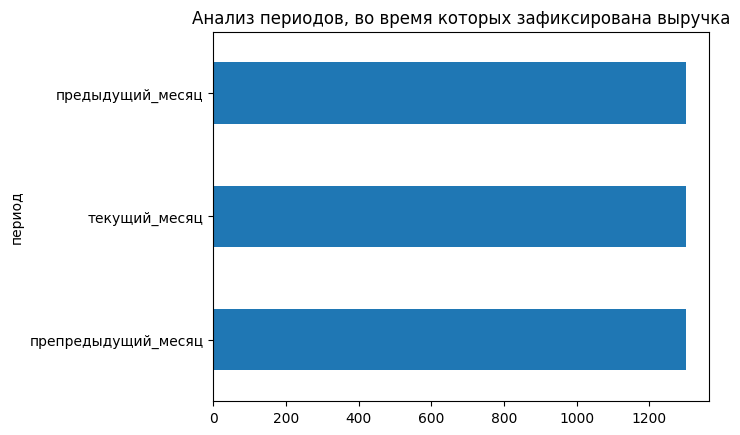

In [96]:
market_money['период'].value_counts().sort_values().plot(kind='barh',title='Анализ периодов, во время которых зафиксирована выручка');

**Комментарий:** Рассмотрены отдельно 3 месяца для каждого клиента (3 по 1300).

- количественный показатель выручка

In [97]:
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

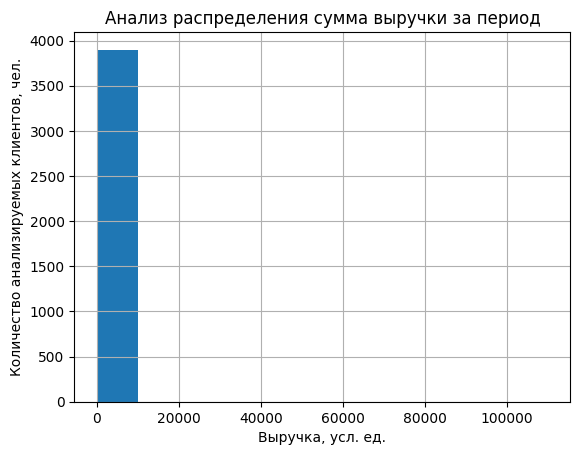

In [98]:
market_money['выручка'].hist(bins=11, range=(0,110000))
plt.title('Анализ распределения сумма выручки за период')
plt.xlabel('Выручка, усл. ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

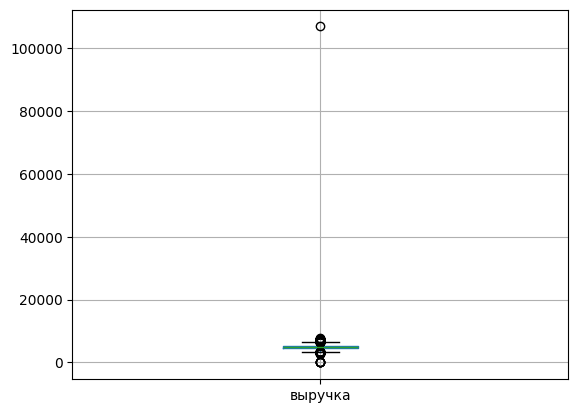

In [99]:
market_money.boxplot(column='выручка');

In [100]:
count_clients = len(market_money[market_money['выручка'] > 100000])
print(f"Число клиентов с суммой выручки > 100 000: {count_clients}")

total_clients = len(market_file)
percentage = (count_clients / total_clients) * 100
print(f"Доля таких клиентов от общей базы: {percentage:.1f}%")

Число клиентов с суммой выручки > 100 000: 1
Доля таких клиентов от общей базы: 0.1%


**Комментарий:** Имеется явный выброс - 1 клиент с выручкой выше 100 000 усл.ед. Предлагаю данное наблюдение заменить медианным значением.

In [101]:
market_money.loc[market_money['выручка'] > 100000, 'выручка'] = market_money['выручка'].median()

In [102]:
market_money['выручка'].describe()

count    3900.000000
mean     4999.566641
std       706.909531
min         0.000000
25%      4590.150000
50%      4957.250000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

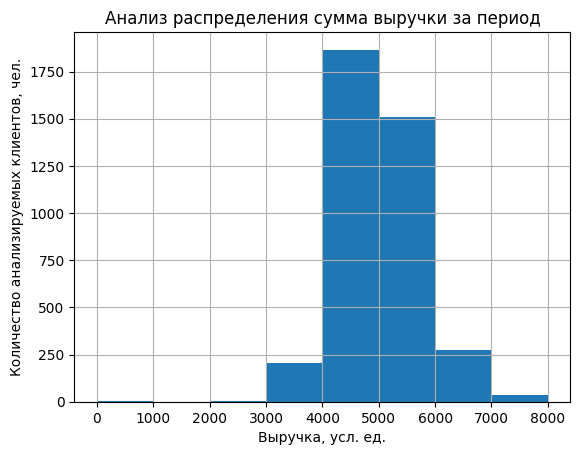

In [103]:
market_money['выручка'].hist(bins=8, range=(0,8000))
plt.title('Анализ распределения сумма выручки за период')
plt.xlabel('Выручка, усл. ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [104]:
stat, p_value = shapiro(market_money['выручка'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9592, p-value=0.000
Не нормальное распределение (отвергаем H0)


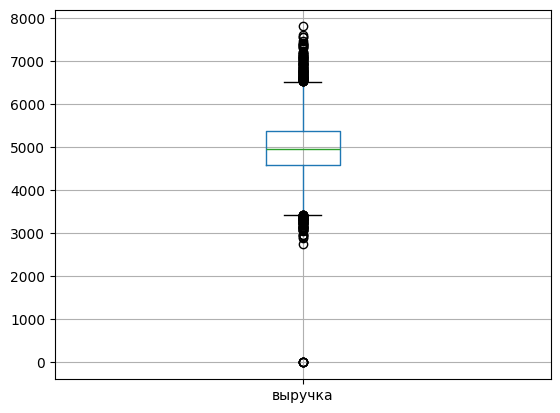

In [105]:
market_money.boxplot(column='выручка');

In [106]:
count_clients = len(market_money[market_money['выручка'] < 1000])
print(f"Число наблюдений с суммой выручки < 1000: {count_clients}")

total_clients = len(market_file)
percentage = (count_clients / total_clients) * 100
print(f"Доля таких наблюдений от общей базы: {percentage:.1f}%")

Число наблюдений с суммой выручки < 1000: 6
Доля таких наблюдений от общей базы: 0.5%


In [107]:
market_money[market_money['выручка'] < 1000]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


**Комментарий:** После обработки выброса распределение выручки демонстрирует нормализованную картину со средним значением 4999,6 усл.ед. и медианой 4957,3 усл.ед. Замена экстремального выброса (выручка > 100000) на медианное значение устранила перекос распределения, что подтверждается близкими значениями среднего и медианы. Распределение приобрело симметричный колоколообразный вид с концентрацией основной массы клиентов в диапазоне 4500-5500 усл.ед. При этом сохраняется незначительная группа из 3 клиентов с нулевой выручкой, что может указывать на неактивных пользователей или технические ошибки в учете. Общая картина свидетельствует о стабильном и однородном профиле покупательской способности клиентской базы.

3.3 market_time

In [108]:
market_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2600 non-null   int64
 1   период  2600 non-null   str  
 2   минут   2600 non-null   int64
dtypes: int64(2), str(1)
memory usage: 61.1 KB


- качественный показатель период

Анализ уникальных значений:

In [109]:
market_time['период'].value_counts()

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

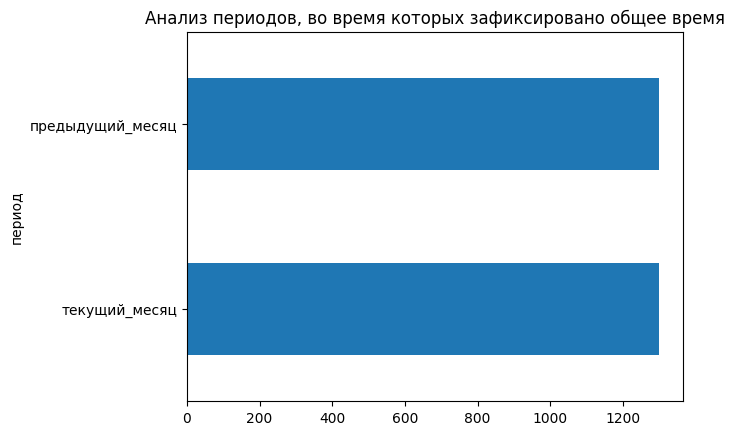

In [110]:
market_time['период'].value_counts().sort_values().plot(kind='barh',title='Анализ периодов, во время которых зафиксировано общее время');

**Комментарий:** Рассмотрены отдельно 2 месяца для каждого клиента (2 по 1300).

- количественный показатель минут

In [111]:
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

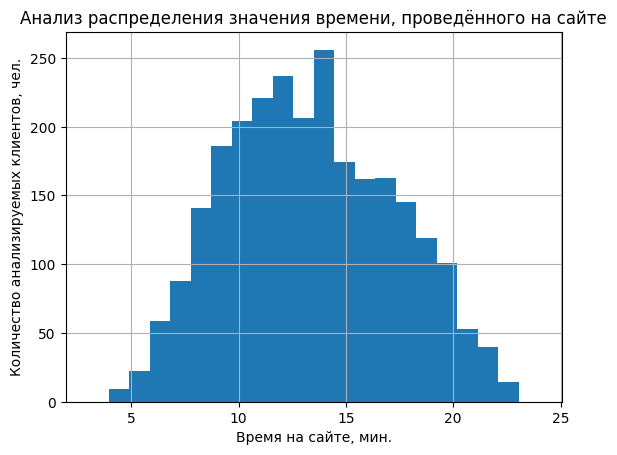

In [112]:
market_time['минут'].hist(bins=22, range=(3,24))
plt.title('Анализ распределения значения времени, проведённого на сайте')
plt.xlabel('Время на сайте, мин.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [113]:
stat, p_value = shapiro(market_time['минут'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9826, p-value=0.000
Не нормальное распределение (отвергаем H0)


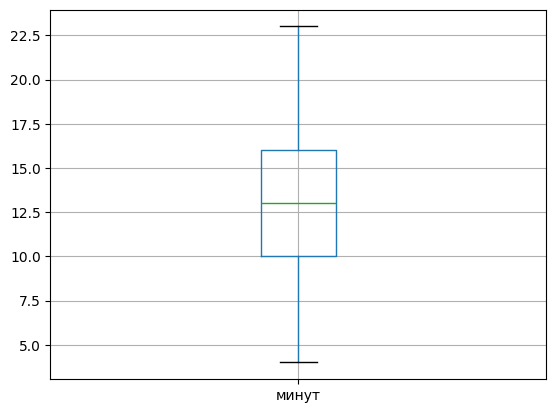

In [114]:
market_time.boxplot(column='минут');

**Комментарий:** Анализ времени пребывания на сайте показывает распределение, близкое к нормальному, со средним значением 13,3 минуты и медианой 13 минут. Распределение имеет слабовыраженную бимодальность с пиками активности на 12 и 14 минутах. Стандартное отклонение 4,1 минуты свидетельствует об умеренном разбросе - большинство клиентов проводят на сайте от 10 до 16 минут. Экстремальные значения отсутствуют.

3.4 money

In [115]:
money.info()

<class 'pandas.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


- количественный показатель прибыль

In [116]:
money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

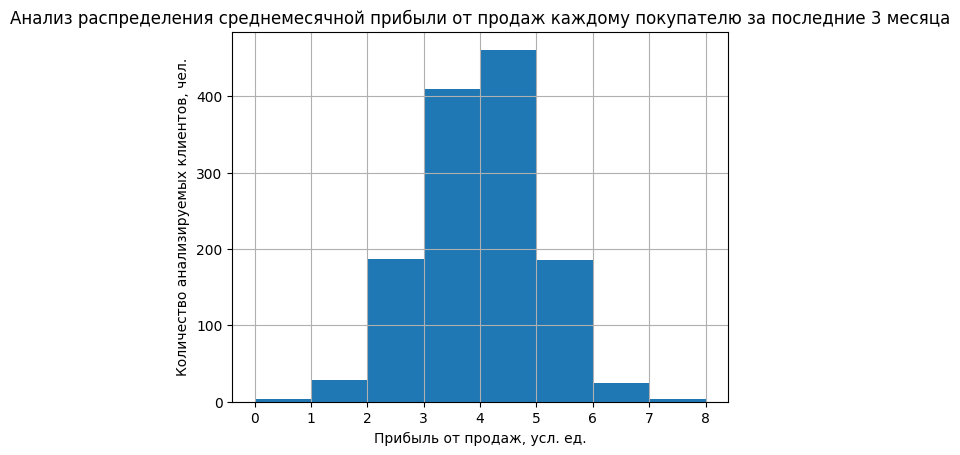

In [117]:
money['прибыль'].hist(bins=8, range=(0,8))
plt.title('Анализ распределения среднемесячной прибыли от продаж каждому покупателю за последние 3 месяца')
plt.xlabel('Прибыль от продаж, усл. ед.')
plt.ylabel('Количество анализируемых клиентов, чел.')
plt.show()

In [118]:
stat, p_value = shapiro(money['прибыль'])
print(f'Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.3f}')

if p_value > 0.05:
    print('Нормальное распределение (не отвергаем H0)')
else:
    print('Не нормальное распределение (отвергаем H0)')

Shapiro-Wilk test: statistic=0.9984, p-value=0.258
Нормальное распределение (не отвергаем H0)


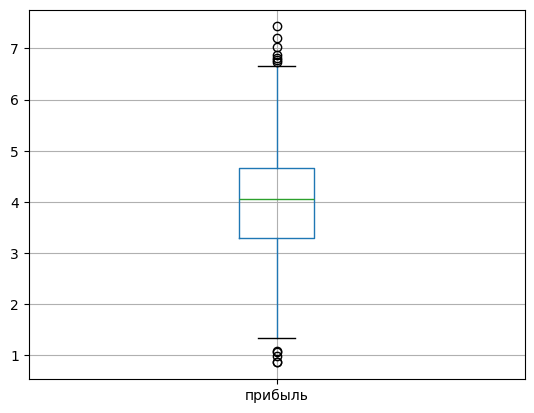

In [119]:
money.boxplot(column='прибыль');

**Комментарий:** Анализ распределения прибыли демонстрирует близкое к нормальному распределение со средним значением 4,0 усл.ед. и медианой 4,05 усл.ед. Тест Шапиро-Уилка (p-value = 0,258) подтверждает нормальность распределения, что является редким случаем для бизнес-метрик. Распределение симметрично с концентрацией основной массы клиентов в диапазоне 3,3-4,7 усл.ед., что охватывает 50% клиентской базы. Есть ряд неярко выраженных выбросов.

2.4 Отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

Проверим выручку по клиентам и месяцам:

In [120]:
client_activity = market_money.pivot_table(
    index='id', 
    columns='период', 
    values='выручка', 
    aggfunc='sum'
).reset_index()

Переименуем столбцы для удобства:

In [121]:
client_activity.columns = ['id', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']

In [122]:
client_activity[['выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']].describe()

,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5236.572615
std,739.597997,405.979663,835.188961
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.550000
75%,5405.625000,5053.500000,5759.275000
max,6869.500000,5663.000000,7799.400000


Определим активных клиентов (тех, у кого выручка > 0 в каждом месяце):

In [123]:
client_activity['активных_месяцев'] = (
    (client_activity['выручка_препредыдущий'] > 0).astype(int) +
    (client_activity['выручка_предыдущий'] > 0).astype(int) +
    (client_activity['выручка_текущий'] > 0).astype(int)
)
client_activity['активных_месяцев'].value_counts().sort_index()

активных_месяцев
1       3
3    1297
Name: count, dtype: int64

Отберем клиентов с активностью не менее 3 месяцев (покупали во всех трех месяцах):

In [124]:
active_clients_ids = client_activity[client_activity['активных_месяцев'] >= 3]['id'].tolist()

In [125]:
print(f'Количество клиентов с активностью не менее 3 месяцев: {len(active_clients_ids)}')
print(f'Доля от общей базы: {len(active_clients_ids)/len(client_activity)*100:.1f}%')

Количество клиентов с активностью не менее 3 месяцев: 1297
Доля от общей базы: 99.8%


In [126]:
nonactive_clients_ids = client_activity[client_activity['активных_месяцев'] < 3]['id'].tolist()
print('id неактивных пользователей:', nonactive_clients_ids)

id неактивных пользователей: [215348, 215357, 215359]


In [127]:
print(f'Количество клиентов с активностью менее 3 месяцев: {len(nonactive_clients_ids)}')
print(f'Доля от общей базы: {len(nonactive_clients_ids)/len(client_activity)*100:.1f}%')

Количество клиентов с активностью менее 3 месяцев: 3
Доля от общей базы: 0.2%


**Выводы по Шагу 3:**

Общая характеристика данных:

1. Качественные показатели:

- Целевая переменная: Дисбаланс классов - 62% клиентов сохранили прежний уровень активности, 38% снизили
- Тип сервиса: Преобладают клиенты со стандартным сервисом (71%) над премиум (29%)
- Согласие на рассылку: 74% клиентов дали разрешение на получение сообщений
- Популярные категории: Четкая иерархия предпочтений с лидером "товары для детей" (25% клиентов)

2. Количественные показатели:

- Маркетинговая активность:

    - Стабильная коммуникационная политика (среднее 4.25 коммуникаций за 6 месяцев)
    - Высокая стандартизация в текущем месяце (75% клиентов получают ровно 4 коммуникации)

- Поведенческие метрики:

    - Акционные покупки: Выраженная поляризация - 10.6% "акционных охотников" (>90% покупок по акциям)
    - Просмотр категорий: Умеренная активность (медиана 3 категории за визит)
    - Глубина просмотра: Широкий разброс от 1 до 20 страниц за визит
    - Неоплаченные товары: Типичное поведение "отложенных покупок" (1-4 товара)
    
- Технические показатели:

    - Сбои сервиса: Умеренно высокий уровень проблем (медиана 4 сбоя за 3 месяца)
    - Время на сайте: Стабильное распределение (13.3 минуты в среднем)

3. Финансовые показатели:

- Выручка:

    - Обработан экстремальный выброс (1 клиент с выручкой >100,000 заменен на медиану)
    - Стабильное распределение после обработки (среднее ~5000 усл.ед.)
    - Выявлено 3 клиента с нулевой выручкой в некоторых месяцах

- Прибыль:

- Редкий случай нормального распределения бизнес-метрики
- Стабильные показатели прибыльности (среднее 4.0 усл.ед.)

Ключевой результат - отбор активных клиентов:

- Критерий отбора: Клиенты с покупательской активностью не менее трёх месяцев (покупали во всех трех анализируемых месяцах)
- Активные клиенты: 1297 клиентов (99.8% от общей базы)
- Неактивные клиенты: 3 клиента (0.2%) - id: 215348, 215357, 215359

Выявленные особенности для моделирования:

- Дисбаланс классов в целевой переменной требует применения соответствующих техник (взвешивание классов, SMOTE)
- Поляризация по акционным покупкам указывает на разные стратегии взаимодействия с клиентами
- Технические сбои могут существенно влиять на покупательскую активность
- Разнообразие поведенческих паттернов требует сегментации клиентов

Данные полностью проанализированы, отобрана релевантная выборка из 1297 активных клиентов для построения модели прогнозирования снижения покупательской активности.

# Шаг 4. Объединение таблиц

4.1 Подготовка данных для объединения

- Подготовка данных market_money (выручка по периодам)

Создаем сводную таблицу для выручки с отдельными столбцами для каждого периода:

In [128]:
money_pivot = market_money.pivot_table(
    index='id', 
    columns='период', 
    values='выручка', 
    aggfunc='sum'
).reset_index()
money_pivot.head(3)

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4


Переименуем столбцы для ясности:

In [129]:
money_pivot.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
money_pivot.head(3)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4


In [130]:
print(f'Размерность таблицы выручки после преобразования: {money_pivot.shape}')
print('Столбцы таблицы выручки')
print(money_pivot.columns.tolist())

Размерность таблицы выручки после преобразования: (1300, 4)
Столбцы таблицы выручки
['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


- Подготовка данных market_time (время на сайте по периодам)

Создаем сводную таблицу для времени с отдельными столбцами для каждого периода:

In [131]:
time_pivot = market_time.pivot_table(
    index='id', 
    columns='период', 
    values='минут', 
    aggfunc='sum'
).reset_index()
time_pivot.head(3)

период,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13


Переименуем столбцы для ясности:

In [132]:
time_pivot.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
time_pivot.head(3)

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13


In [133]:
print(f'Размерность таблицы времени после преобразования: {time_pivot.shape}')
print('Столбцы таблицы времени:')
print(time_pivot.columns.tolist())

Размерность таблицы времени после преобразования: (1300, 3)
Столбцы таблицы времени:
['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


4.2 Объединение таблиц

Объединяем основную таблицу с таблицей выручки:

In [134]:
merged_data = pd.merge(market_file, money_pivot, on='id', how='inner')
merged_data.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.0,0.0,3293.1
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4


In [135]:
print(f'Размерность после объединения с выручкой: {merged_data.shape}')

Размерность после объединения с выручкой: (1300, 16)


Объединяем с таблицей времени:

In [136]:
merged_data = pd.merge(merged_data, time_pivot, on='id', how='inner')
merged_data.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13


In [137]:
print(f'Размерность после объединения с временем: {merged_data.shape}')

Размерность после объединения с временем: (1300, 18)


4.3 Фильтрация активных клиентов (из шага 3)

Используем список active_clients_ids из предыдущего шага:

In [138]:
initial_count = len(merged_data)
merged_data = merged_data[merged_data['id'].isin(active_clients_ids)]

In [139]:
print(f'Количество записей до фильтрации: {initial_count}')
print(f'Количество записей после фильтрации активных клиентов: {len(merged_data)}')
print(f'Отфильтровано записей: {initial_count - len(merged_data)}')

Количество записей до фильтрации: 1300
Количество записей после фильтрации активных клиентов: 1297
Отфильтровано записей: 3


Информация об итоговой таблице:

In [140]:
merged_data.info()

<class 'pandas.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   str    
 2   тип_сервиса                          1297 non-null   str    
 3   разрешить_сообщать                   1297 non-null   str    
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   str    
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                       1297 non-

In [141]:
merged_data.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,4948.339630,4836.367772,5237.879722,13.469545,13.211257
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,701.228571,333.438742,834.033166,3.936323,4.220222
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.500000,4585.000000,4706.600000,11.000000,10.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4812.000000,5179.600000,13.000000,13.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5409.000000,5055.000000,5758.600000,17.000000,16.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


4.4 Сохранение итоговой таблицы для дальнейшего анализа:

In [142]:
data = merged_data.copy()
data.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13


In [143]:
print(f'Итоговая размерность таблицы: {data.shape}')
print(f'Количество признаков: {data.shape[1]}')
print(f'Количество клиентов: {data.shape[0]}')

Итоговая размерность таблицы: (1297, 18)
Количество признаков: 18
Количество клиентов: 1297


**Выводы по Шагу 4:**

Преобразование формата данных:

Выручка: Созданы отдельные столбцы для каждого периода:
- выручка_предыдущий_месяц
- выручка_препредыдущий_месяц
- выручка_текущий_месяц

Время на сайте: Созданы отдельные столбцы:
- минут_предыдущий_месяц
- минут_текущий_месяц

Объединение таблиц:

- Все три таблицы (market_file, market_money, market_time) успешно объединены
- Тип объединения: inner join по id для сохранения только общих записей

Результаты объединения:

- Размерность данных:
    - Исходные данные: 1300 клиентов
    - После фильтрации активных клиентов: 1297 клиентов
    - Отфильтровано: 3 неактивных клиента (0,2% от общей базы)
    - Количество признаков: 18 столбцов

Итоговая таблица полностью готова для перехода к Шагу 5: Корреляционный анализ и последующему построению моделей машинного обучения.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично! Таблицы <code>market_money, market_time</code> переведены из «длинной» в «широкую», в каждой строке информация об уникальном клиенте. Объединение с <code>market_file</code> выполнено верно.
</div>

# Шаг 5. Корреляционный анализ

5.1 Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.

Выделим только количественные признаки для корреляционного анализа:

In [144]:
data.info()

<class 'pandas.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   str    
 2   тип_сервиса                          1297 non-null   str    
 3   разрешить_сообщать                   1297 non-null   str    
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   str    
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                       1297 non-

!!! Для дополнительного анализа выделяем данные для двух групп покупательской активности:

In [145]:
active_data = data[data['покупательская_активность'] == 'прежний_уровень']
decreased_data = data[data['покупательская_активность'] == 'снизилась']

print(f'Размерность данных для группы "Прежний уровень": {active_data.shape}')
print(f'Размерность данных для группы "Снизилась": {decreased_data.shape}')

Размерность данных для группы "Прежний уровень": (802, 18)
Размерность данных для группы "Снизилась": (495, 18)


In [146]:
quantitative_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

Исключаем id из анализа, так как это не признак для модели:

In [147]:
quantitative_columns.remove('id')

In [148]:
print(f'Количественные признаки для анализа:')
for i, col in enumerate(quantitative_columns, 1):
    print(f'{i:2d}. {col}')

Количественные признаки для анализа:
 1. маркет_актив_6_мес
 2. маркет_актив_тек_мес
 3. длительность
 4. акционные_покупки
 5. средний_просмотр_категорий_за_визит
 6. неоплаченные_продукты_штук_квартал
 7. ошибка_сервиса
 8. страниц_за_визит
 9. выручка_предыдущий_месяц
10. выручка_препредыдущий_месяц
11. выручка_текущий_месяц
12. минут_предыдущий_месяц
13. минут_текущий_месяц


Создаем таблицу только с количественными признаками:

In [149]:
quantitative_data = data[quantitative_columns]
active_quantitative_data = active_data[quantitative_columns]
decreased_quantitative_data = decreased_data[quantitative_columns]

In [150]:
print(f'Размерность данных для корреляционного анализа: {quantitative_data.shape}')
print(f'Размерность данных для корреляционного анализа для группы "Прежний уровень": {active_quantitative_data.shape}')
print(f'Размерность данных для корреляционного анализа для группы "Снизилась": {decreased_quantitative_data.shape}')

Размерность данных для корреляционного анализа: (1297, 13)
Размерность данных для корреляционного анализа для группы "Прежний уровень": (802, 13)
Размерность данных для корреляционного анализа для группы "Снизилась": (495, 13)


Построим матрицу корреляций (используем метод Спирмена (Spearman), т.к. большинство признаков не распределены нормально):

In [151]:
correlation_matrix = quantitative_data.corr(method='spearman').round(2)
correlation_matrix 

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
маркет_актив_6_мес,1.00,0.06,-0.04,-0.28,0.19,-0.13,0.04,0.32,-0.01,0.23,0.00,0.27,0.23
маркет_актив_тек_мес,0.06,1.00,-0.13,0.03,-0.03,0.06,0.09,0.00,-0.03,-0.04,-0.01,0.01,-0.06
длительность,-0.04,-0.13,1.00,0.03,-0.04,-0.11,0.10,-0.03,0.01,-0.04,0.01,-0.12,0.08
акционные_покупки,-0.28,0.03,0.03,1.00,-0.20,0.20,-0.05,-0.37,0.01,-0.27,0.02,-0.33,-0.27
средний_просмотр_категорий_за_визит,0.19,-0.03,-0.04,-0.20,1.00,-0.25,0.01,0.27,-0.05,0.15,-0.07,0.15,0.23
неоплаченные_продукты_штук_квартал,-0.13,0.06,-0.11,0.20,-0.25,1.00,-0.10,-0.17,0.03,-0.25,0.06,-0.18,-0.21
ошибка_сервиса,0.04,0.09,0.10,-0.05,0.01,-0.10,1.00,0.10,0.04,0.09,0.04,0.20,0.08
страниц_за_визит,0.32,0.00,-0.03,-0.37,0.27,-0.17,0.10,1.00,-0.07,0.31,-0.05,0.45,0.30
выручка_предыдущий_месяц,-0.01,-0.03,0.01,0.01,-0.05,0.03,0.04,-0.07,1.00,0.31,0.88,-0.08,-0.08
выручка_препредыдущий_месяц,0.23,-0.04,-0.04,-0.27,0.15,-0.25,0.09,0.31,0.31,1.00,0.15,0.35,0.30


In [152]:
active_correlation_matrix = active_quantitative_data.corr(method='spearman').round(2)
active_correlation_matrix 

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
маркет_актив_6_мес,1.00,0.09,0.00,-0.06,0.03,0.09,-0.05,0.04,0.04,0.03,0.06,-0.02,-0.00
маркет_актив_тек_мес,0.09,1.00,-0.13,0.06,0.06,0.10,0.10,0.04,-0.06,-0.06,-0.03,0.07,-0.09
длительность,0.00,-0.13,1.00,-0.04,-0.12,-0.15,0.13,-0.05,0.00,-0.03,-0.03,-0.14,0.20
акционные_покупки,-0.06,0.06,-0.04,1.00,-0.01,0.05,0.04,0.00,-0.07,-0.08,-0.07,0.01,0.00
средний_просмотр_категорий_за_визит,0.03,0.06,-0.12,-0.01,1.00,-0.03,-0.07,0.01,-0.06,-0.08,-0.08,-0.14,0.10
неоплаченные_продукты_штук_квартал,0.09,0.10,-0.15,0.05,-0.03,1.00,-0.06,0.19,0.03,-0.15,0.06,-0.01,-0.14
ошибка_сервиса,-0.05,0.10,0.13,0.04,-0.07,-0.06,1.00,-0.03,0.01,0.02,-0.02,0.18,0.02
страниц_за_визит,0.04,0.04,-0.05,0.00,0.01,0.19,-0.03,1.00,-0.04,-0.03,-0.03,0.05,-0.12
выручка_предыдущий_месяц,0.04,-0.06,0.00,-0.07,-0.06,0.03,0.01,-0.04,1.00,0.42,0.87,-0.07,-0.03
выручка_препредыдущий_месяц,0.03,-0.06,-0.03,-0.08,-0.08,-0.15,0.02,-0.03,0.42,1.00,0.21,0.07,0.09


In [153]:
decreased_correlation_matrix = decreased_quantitative_data.corr(method='spearman').round(2)
decreased_correlation_matrix 

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
маркет_актив_6_мес,1.00,0.01,-0.04,-0.15,0.06,-0.15,0.07,0.26,-0.02,0.20,-0.02,0.25,0.19
маркет_актив_тек_мес,0.01,1.00,-0.13,-0.00,-0.17,0.02,0.05,-0.09,0.02,-0.03,0.00,-0.10,-0.10
длительность,-0.04,-0.13,1.00,0.05,0.19,-0.11,0.09,0.16,0.02,0.01,0.08,-0.03,-0.02
акционные_покупки,-0.15,-0.00,0.05,1.00,-0.02,0.08,-0.02,-0.26,0.05,-0.13,0.05,-0.25,-0.17
средний_просмотр_категорий_за_визит,0.06,-0.17,0.19,-0.02,1.00,-0.33,0.02,0.19,-0.00,0.14,0.01,0.04,-0.01
неоплаченные_продукты_штук_квартал,-0.15,0.02,-0.11,0.08,-0.33,1.00,-0.08,-0.23,-0.00,-0.15,0.00,0.04,0.03
ошибка_сервиса,0.07,0.05,0.09,-0.02,0.02,-0.08,1.00,0.21,0.10,0.09,0.17,0.11,0.02
страниц_за_визит,0.26,-0.09,0.16,-0.26,0.19,-0.23,0.21,1.00,-0.06,0.34,0.04,0.39,0.31
выручка_предыдущий_месяц,-0.02,0.02,0.02,0.05,-0.00,-0.00,0.10,-0.06,1.00,0.29,0.89,-0.07,-0.15
выручка_препредыдущий_месяц,0.20,-0.03,0.01,-0.13,0.14,-0.15,0.09,0.34,0.29,1.00,0.21,0.38,0.19


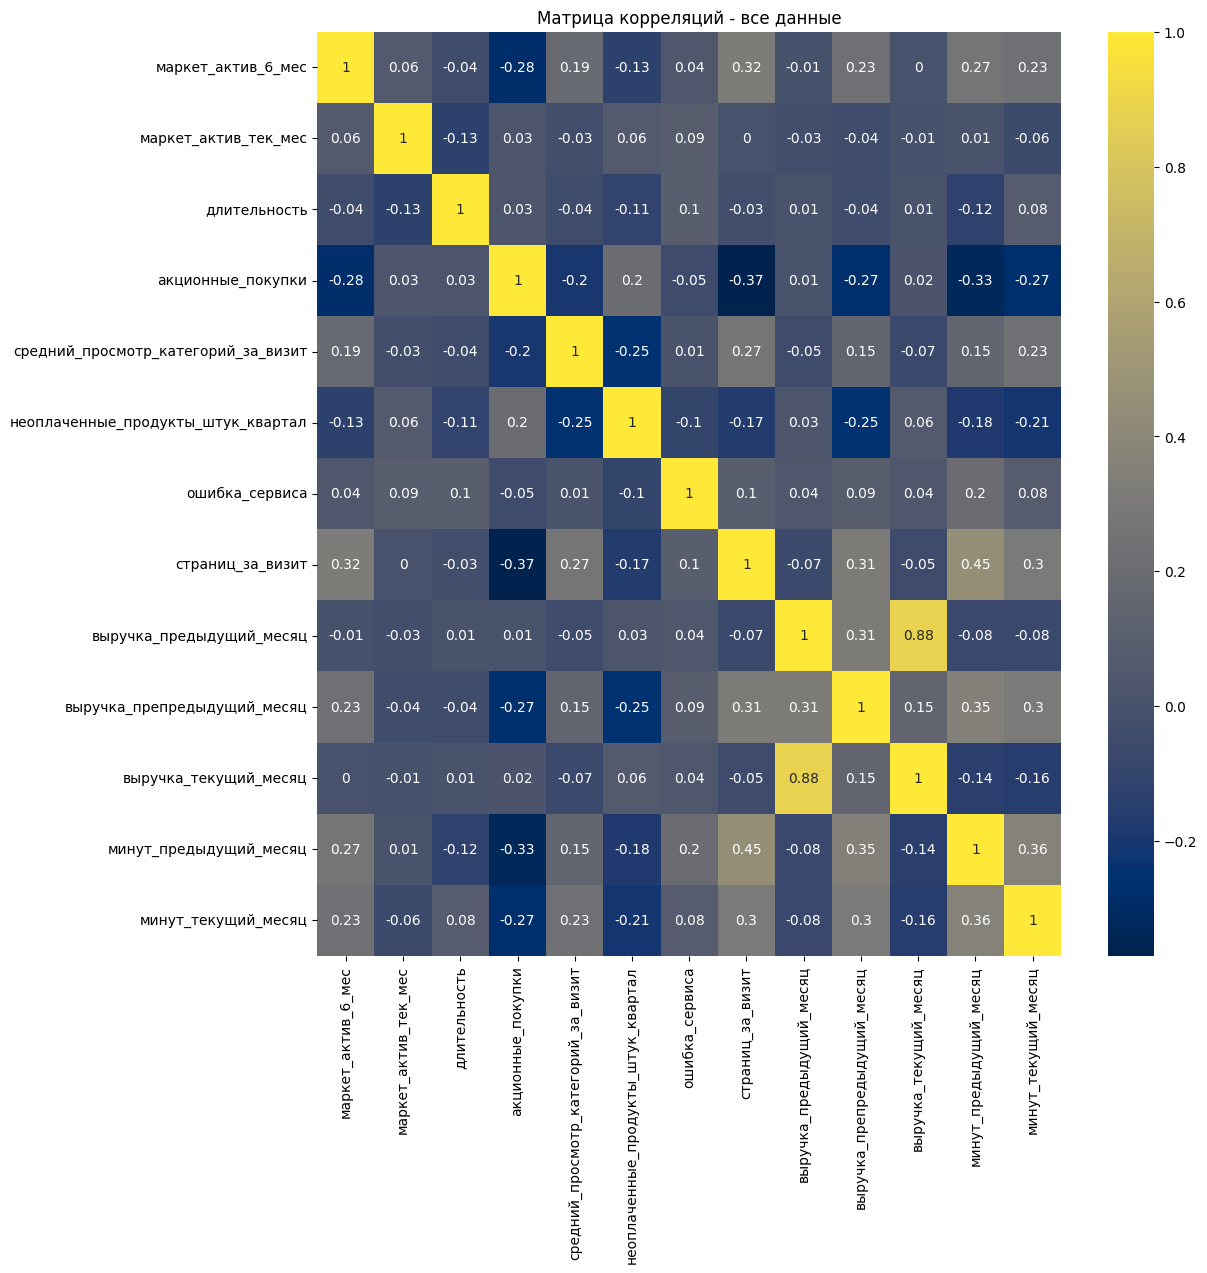

In [154]:
plt.figure(figsize=(12, 12))
sns.heatmap(quantitative_data.corr(method='spearman').round(2), 
            annot=True, cmap='cividis')
plt.title('Матрица корреляций - все данные');

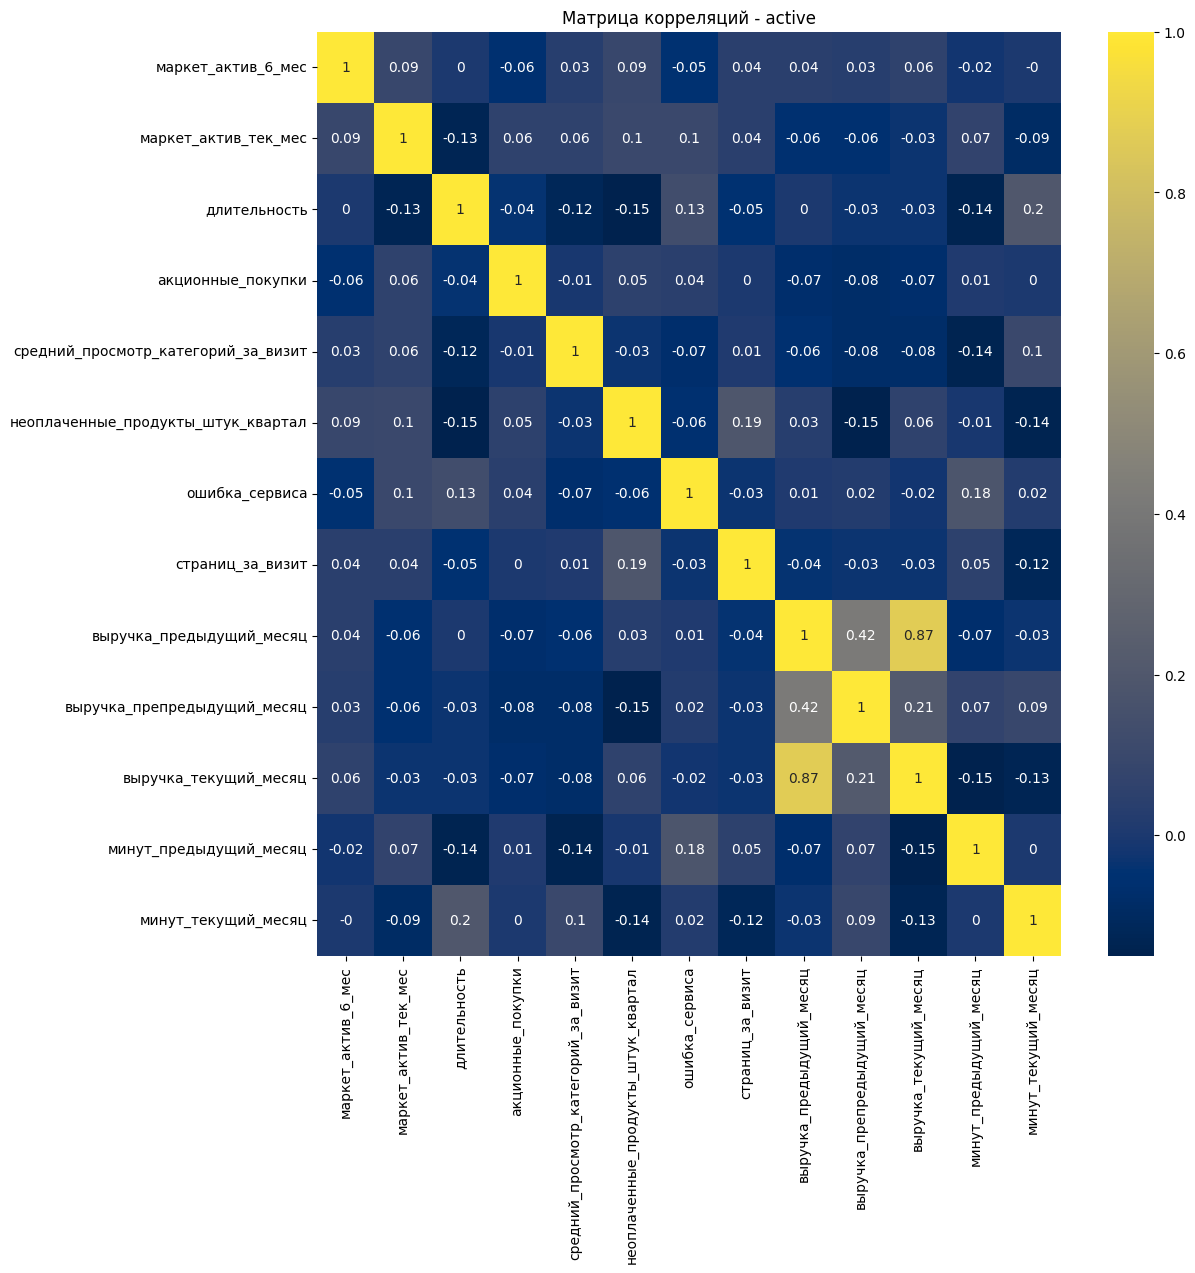

In [155]:
plt.figure(figsize=(12, 12))
sns.heatmap(active_quantitative_data.corr(method='spearman').round(2), 
            annot=True, cmap='cividis')
plt.title('Матрица корреляций - active');

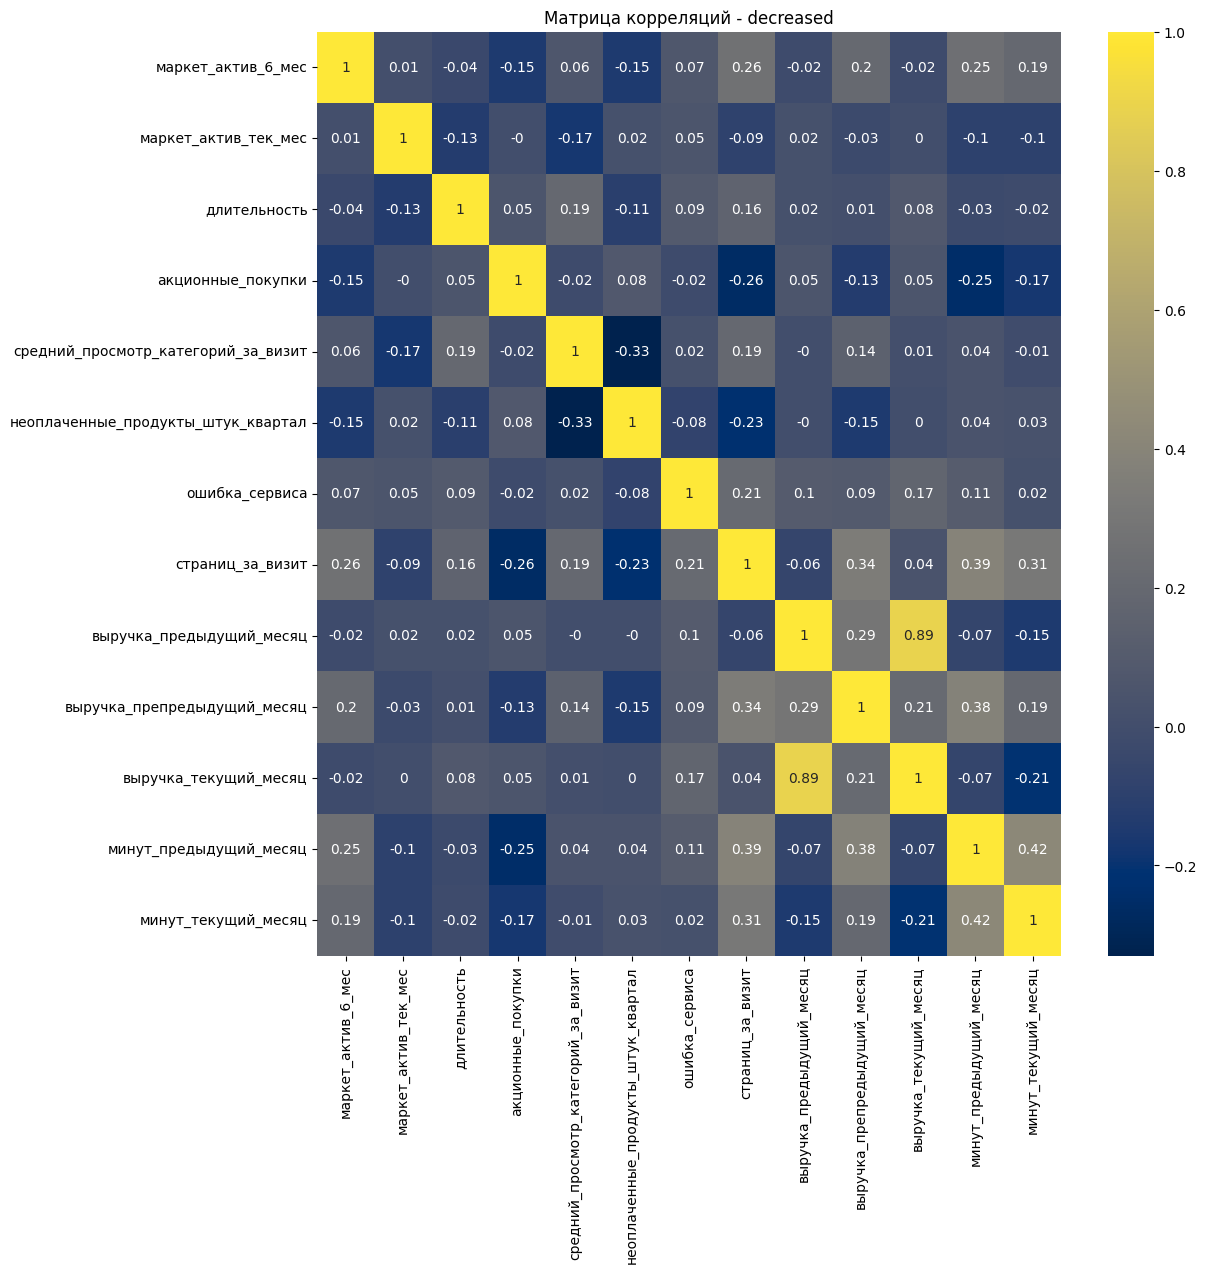

In [156]:
plt.figure(figsize=(12, 12))
sns.heatmap(decreased_quantitative_data.corr(method='spearman').round(2), 
            annot=True, cmap='cividis')
plt.title('Матрица корреляций - decreased');

**Комментарий:** Имеется сильная взаимосвязь между выручка_текущий_месяц и выручка_предыдущий_месяц. Одновременное использование данных показателей в модели приведет к проблеме мультиколлинеарности. В этой связь можно 1) исключить из рассмотрения один из параметров либо 2) создать новый показатель, например, сумма либо средняя выручка в текущем и предыдущем месяце.

Создадим новые переменные:

In [157]:
data['выручка_текущий_предыдущий_месяц_сумм'] = data['выручка_текущий_месяц'] + data['выручка_предыдущий_месяц']
data['выручка_текущий_предыдущий_месяц_ср'] = (data['выручка_текущий_месяц'] + data['выручка_предыдущий_месяц'])/2 
data[['выручка_текущий_предыдущий_месяц_сумм',
      'выручка_текущий_предыдущий_месяц_ср',
      'выручка_текущий_месяц',
      'выручка_предыдущий_месяц']].head(3)

,выручка_текущий_предыдущий_месяц_сумм,выручка_текущий_предыдущий_месяц_ср,выручка_текущий_месяц,выручка_предыдущий_месяц
1,10187.6,5093.80,4971.6,5216.0
2,10515.9,5257.95,5058.4,5457.5
3,12768.4,6384.20,6610.4,6158.0


5.2 Проведем корреляционный анализ между всеми анализируемыми показателями

Используем библиотеку phik для подсчёта корреляции между признаками разных типов данных:

In [158]:
quantitative_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
phik_overview = data.drop(columns='id').phik_matrix(interval_cols=quantitative_columns)
phik_overview

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,выручка_текущий_предыдущий_месяц_сумм,выручка_текущий_предыдущий_месяц_ср
покупательская_активность,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.227280,0.495174,0.195470,0.685078,0.575662,0.191705,0.191705
тип_сервиса,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.000000,0.068507,0.123698,0.131084,0.000000,0.000000,0.000000
разрешить_сообщать,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.079830,0.000000,0.062923,0.042350,0.000000,0.000000,0.000000
маркет_актив_6_мес,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.286304,0.147270,0.394108,0.149129,0.312243,0.032055,0.363780,0.328385,0.114623,0.114623
маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.054683,0.000000,0.000000,0.106879,0.062485,0.000000,0.000000
длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.125303,0.114058,0.147580,0.024075,0.100502,0.095415,0.095415
акционные_покупки,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.065412,0.225681,0.069613,0.262189,0.250014,0.066693,0.066693
популярная_категория,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.250974,0.045814,0.237957,0.195219,0.089923,0.208945,0.208945
средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.100332,0.176770,0.092720,0.159393,0.182708,0.082558,0.082558
неоплаченные_продукты_штук_квартал,0.504845,0.120842,0.195442,0.286304,0.143827,0.191923,0.237583,0.248558,0.325688,1.000000,0.033392,0.363879,0.249471,0.261530,0.230430,0.255982,0.232121,0.346829,0.346829


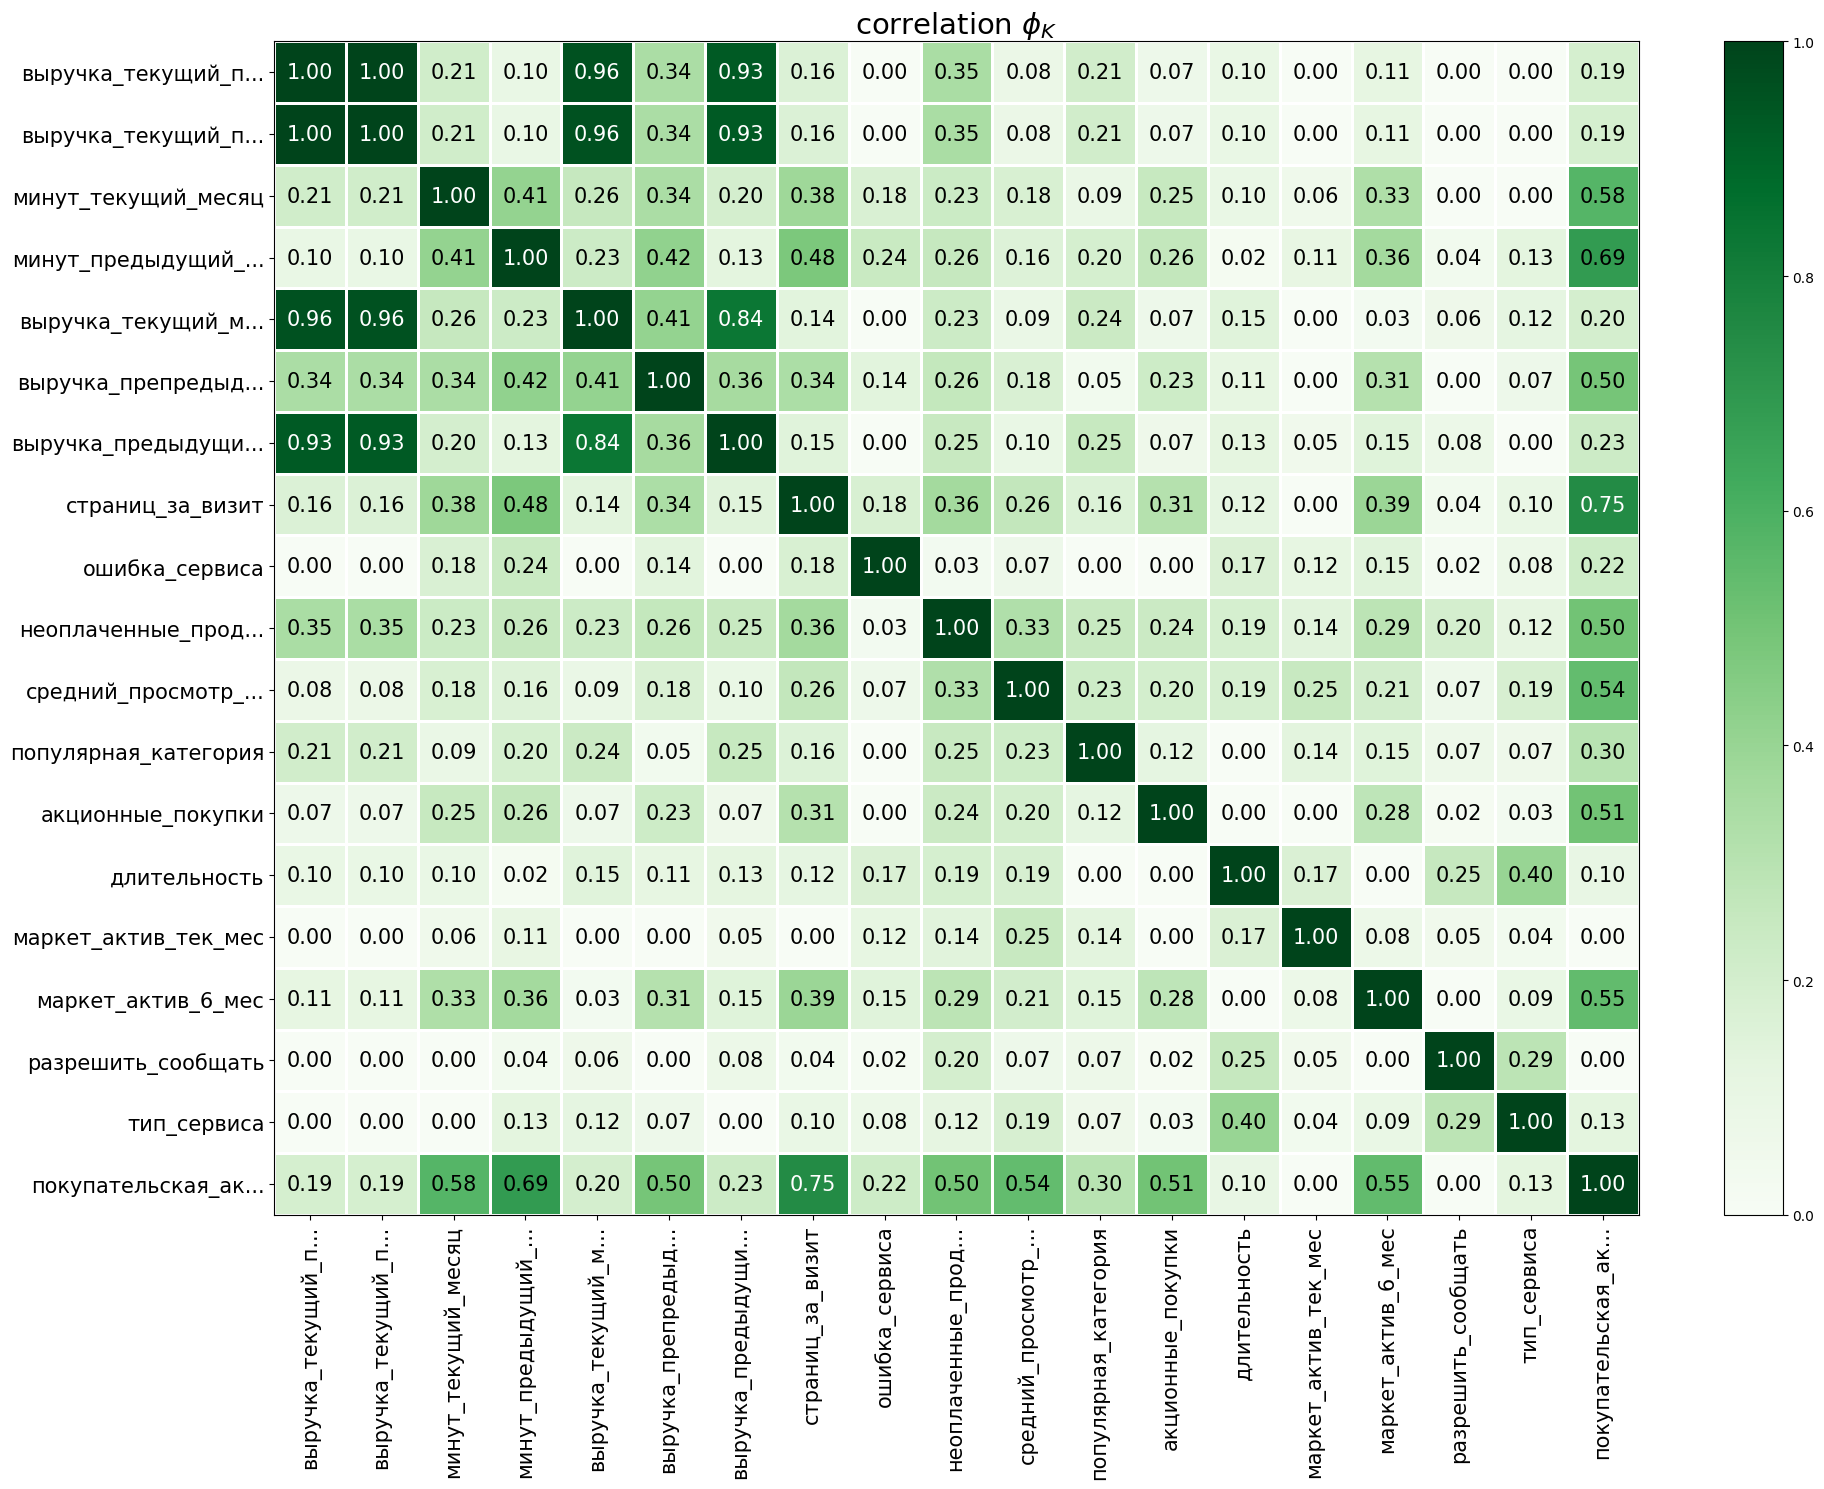

In [159]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Комментарий:**

- На покупательская_активность больше всего влияют:
    - страниц_за_визит (corr = 0,75),
    - минут_предыдущий_месяц (corr = 0,69),
    - минут_текущий_месяц (corr = 0,58),
    - маркет_актив_6_мес (corr = 0,55),
    - средний_просмотр_категорий_за_визит (corr = 0,54),
    - акционные_покупки (corr = 0,51),
    - неоплаченные_продукты_штук_квартал (corr = 0,50),
    - выручка_препредыдущий_месяц (corr = 0,50).
    

- На покупательская_активность не влияют:
    - маркет_актив_тек_мес (corr = 0,0),
    - разрешить_сообщать (corr = 0,0).


- На покупательская_активность больше влияет выручка_предыдущий_месяц (corr = 0,23), чем выручка_текущий_месяц (corr = 0,20) и новые сгенерированные показатели = > для устранения проблемы МК при моделировании предлагаю не использовать показатель выручка_текущий_месяц и новые сгенерированные показатели.

Удалим выручка_текущий_месяц и новые сгенерированные показатели из data:

In [160]:
data_clear = data.drop(columns=['выручка_текущий_месяц',
                                'выручка_текущий_предыдущий_месяц_сумм',
                                'выручка_текущий_предыдущий_месяц_ср'])

Сделаем столбец 'id' индексом:

In [161]:
data_clear = data_clear.set_index('id')

In [162]:
data_clear.info()

<class 'pandas.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   str    
 1   тип_сервиса                          1297 non-null   str    
 2   разрешить_сообщать                   1297 non-null   str    
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   str    
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит                     12

**Выводы по Шагу 5:**

Основные результаты анализа:

1. Выявлена проблема мультиколлинеарности:

- Сильная корреляция между выручка_текущий_месяц и выручка_предыдущий_месяц (0,88 по Спирмену)
- Это создает проблему мультиколлинеарности при моделировании

2. Принято решение по устранению:

- Удален признак: выручка_текущий_месяц
- Обоснование: - более слабая корреляция с целевой переменной (0,20) по сравнению с выручка_предыдущий_месяц (0,23)

Ключевые взаимосвязи с целевой переменной:

1. Сильное влияние (корреляция > 0.5):
- страниц_за_визит (0.75) - самый влиятельный фактор
- минут_предыдущий_месяц (0.69) - время на сайте критически важно
- минут_текущий_месяц (0.58) - текущая активность на сайте
- маркет_актив_6_мес (0.55) - долгосрочная маркетинговая активность
- средний_просмотр_категорий_за_визит (0.54) - широта интересов
- акционные_покупки (0,51) - чувствительность к акциям
- неоплаченные_продукты_штук_квартал (0,50) - поведение с корзиной
- выручка_препредыдущий_месяц (0,50) - историческая финансовая активность

2. Слабое влияние (корреляция < 0.1):
- маркет_актив_тек_мес (0,00) - текущая маркетинговая активность не влияет
- разрешить_сообщать (0,00) - согласие на рассылку не коррелирует с активностью

Качество данных после обработки:
- Мультиколлинеарность устранена
- id установлен как индекс для удобства работы с данными

Итоговый датасет подготовлен для перехода к Шагу 6: Построение пайплайнов и моделей машинного обучения.

# Шаг 6. Использование пайплайнов

6.1 Обработка признаков

Разделяем на признаки и целевую переменную:

In [163]:
X = data_clear.drop('покупательская_активность', axis=1)
y = data_clear['покупательская_активность']

Преобразуем целевую переменную в бинарный формат:

In [164]:
y_binary = (y == 'снизилась').astype(int)

In [165]:
print(f'Размерность признаков: {X.shape}')
print(f'Распределение целевой переменной:')
print(y_binary.value_counts())
print(f'Доля класса "снизилась": {y_binary.mean():.3f}')

Размерность признаков: (1297, 15)
Распределение целевой переменной:
покупательская_активность
0    802
1    495
Name: count, dtype: int64
Доля класса "снизилась": 0.382


Разделяем на тренировочную и тестовую выборки:

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_binary  # Стратификация для сохранения распределения
)

In [167]:
print(f'Размерность тренировочной выборки: {X_train.shape}')
print(f'Размерность тестовой выборки: {X_test.shape}')

Размерность тренировочной выборки: (972, 15)
Размерность тестовой выборки: (325, 15)


Создаём списки с названиями признаков:

In [168]:
data_clear.info()

<class 'pandas.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   str    
 1   тип_сервиса                          1297 non-null   str    
 2   разрешить_сообщать                   1297 non-null   str    
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   str    
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит                     12

In [169]:
data_clear['тип_сервиса'].unique()

<StringArray>
['премиум', 'стандарт']
Length: 2, dtype: str

In [170]:
data_clear['разрешить_сообщать'].unique()

<StringArray>
['да', 'нет']
Length: 2, dtype: str

In [171]:
data_clear['популярная_категория'].unique()

<StringArray>
[                    'товары_для_детей',
                    'домашний_текстиль',
                'косметика_и_аксесуары',
                      'кухонная_посуда',
       'техника_для_красоты_и_здоровья',
 'мелкая_бытовая_техника_и_электроника']
Length: 6, dtype: str

**Комментарий:** С учетом имеющихся данных лучше не использовать OrdinalEncoder, т.к. в рассматриваемых качественных данных отсуствует естественный порядок. Но в связи с условием задачи, рассмотри его применение тоже. 

In [172]:
cat_columns = X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f'Категориальные признаки ({len(cat_columns)}): {cat_columns}')
print(f'Числовые признаки ({len(num_columns)}): {num_columns}')

Категориальные признаки (3): ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
Числовые признаки (12): ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


Создаем кастомный трансформер для замены неизвестных значений:

In [173]:
class UnknownToNanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, unknown_values=None):
        # Инициализируем атрибут unknown_values
        self.unknown_values = unknown_values or ['', ' ', 'unknown', 'Unknown', 'NULL', 'null', 'NaN', 'nan']
    
    def fit(self, X, y=None):
        # В fit можно сохранить информацию о тренировочных категориях
        # для более точного определения неизвестных значений
        return self
    
    def transform(self, X):
        X = X.copy()
        if hasattr(X, 'iloc'):  # для pandas DataFrame
            X = X.replace(self.unknown_values, np.nan)
        else:  # для numpy array
            X = np.where(np.isin(X, self.unknown_values), np.nan, X)
        return X

Пайплайн для категориальных признаков с OneHotEncoder

In [174]:
ohe_pipe = Pipeline([
    ('replace_unknown', UnknownToNanTransformer()),
    ('simpleImputer_ohe', SimpleImputer(
        missing_values=np.nan, 
        strategy='most_frequent')),
    ('ohe', OneHotEncoder(
        drop='first',
        handle_unknown='error',
        sparse_output=False))
])

Пайплайн для категориальных признаков с OrdinalEncoder

In [175]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создаем несколько вариантов препроцессинга для тестирования

In [176]:
preprocessor_ohe_standard = ColumnTransformer([
    ('cat_ohe', ohe_pipe, cat_columns),
    ('num_standard', StandardScaler(), num_columns)
])

preprocessor_ohe_minmax = ColumnTransformer([
    ('cat_ohe', ohe_pipe, cat_columns),
    ('num_minmax', MinMaxScaler(), num_columns)
])

preprocessor_ordinal_standard = ColumnTransformer([
    ('cat_ordinal', ord_pipe, cat_columns),
    ('num_standard', StandardScaler(), num_columns)
])

preprocessor_ordinal_minmax = ColumnTransformer([
    ('cat_ordinal', ord_pipe, cat_columns),
    ('num_robust', MinMaxScaler(), num_columns)
])

6.2 Модели

Создаём итоговый пайплайн - подготовка данных и модель:

In [177]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor_ohe_standard),
    ('models', KNeighborsClassifier())
])

Параметры для RandomizedSearchCV:

In [178]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'preprocessor': [preprocessor_ohe_standard, preprocessor_ohe_minmax,
                         preprocessor_ordinal_standard, preprocessor_ordinal_minmax],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 15)   
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'preprocessor': [preprocessor_ohe_standard, preprocessor_ohe_minmax,
                         preprocessor_ordinal_standard, preprocessor_ordinal_minmax],
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5) 
    },

    # словарь для модели LogisticRegression()
    {
        'preprocessor': [preprocessor_ohe_standard, preprocessor_ohe_minmax,
                         preprocessor_ordinal_standard, preprocessor_ordinal_minmax],        
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5) 
    },
    
    # словарь для модели SVC()
    {
        'preprocessor': [preprocessor_ohe_standard, preprocessor_ohe_minmax,
                         preprocessor_ordinal_standard, preprocessor_ordinal_minmax],        
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': np.logspace(-3, 3, 10),
        'models__kernel': ['linear', 'rbf', 'poly']
    }
]

6.3 Выбор лучшей модели

**Комментарий:** Перед поиском по гиперпараметрам моделей нужно определиться с выбором используемой метрики.

Обоснование выбора метрики:

Задача: Прогнозирование снижения покупательской активности

Особенности:
- Дисбаланс классов (38% снизилась, 62% прежний уровень)
- Бизнес-стоимость ошибок:
  - False Positive: Направили предложение клиенту, который не собирался уходить (минимальные потери)
  - False Negative: Не направили предложение клиенту, который уходит (потеря клиента)
  
Выбранная метрика: ROC-AUC
Причины:
1. Устойчивость к дисбалансу классов
2. Учитывает и precision, и recall
3. Оптимальна для задач бинарной классификации с неравными затратами на ошибки
4. Позволяет выбрать оптимальный порог классификации под бизнес-задачу

Запускаем поиск по гиперпараметрам:

In [179]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1 
)

Обучение моделей:

In [180]:
randomized_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","[{'models': [KNeighborsClassifier()], 'models__n_neighbors': range(3, 15), 'preprocessor': [ColumnTransfo...щий_месяц'])]), ColumnTransfo...щий_месяц'])]), ...]}, {'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 5), 'preprocessor': [ColumnTransfo...щий_месяц'])]), ColumnTransfo...щий_месяц'])]), ...]}, ...]"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold`

Лучшая модель и её параметры:

In [181]:
print(f"Модель: {randomized_search.best_estimator_['models']}")
print(f"Препроцессор: {randomized_search.best_estimator_['preprocessor']}")
print(f"Лучшие параметры: {randomized_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {randomized_search.best_score_:.4f}")

Модель: SVC(C=np.float64(0.1), probability=True, random_state=42)
Препроцессор: ColumnTransformer(transformers=[('cat_ordinal',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['тип_сервиса', 'разрешить_сообщать',
                                  'популярная_категория']),
                                ('num_standard', StandardScaler(),
                                 ['маркет_актив_6_мес', 'маркет_актив_тек_мес',
         

Предсказания на тестовой выборке:

In [182]:
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
y_test_pred = randomized_search.predict(X_test)

Метрики для тестовой выборки:

In [183]:
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)
print(f'ROC-AUC: {test_roc_auc:.4f}')
print(f'F1-Score: {test_f1:.4f}')

ROC-AUC: 0.9255
F1-Score: 0.8734


Матрица ошибок:

In [184]:
confusion = np.zeros((2, 2)).astype(np.int64)
for i in range(2):
   for j in range(2):
            confusion[i][j] = np.sum(np.logical_and(y_test == i, y_test_pred == j))

# выведем результат на экран
print(confusion)

[[196   5]
 [ 24 100]]


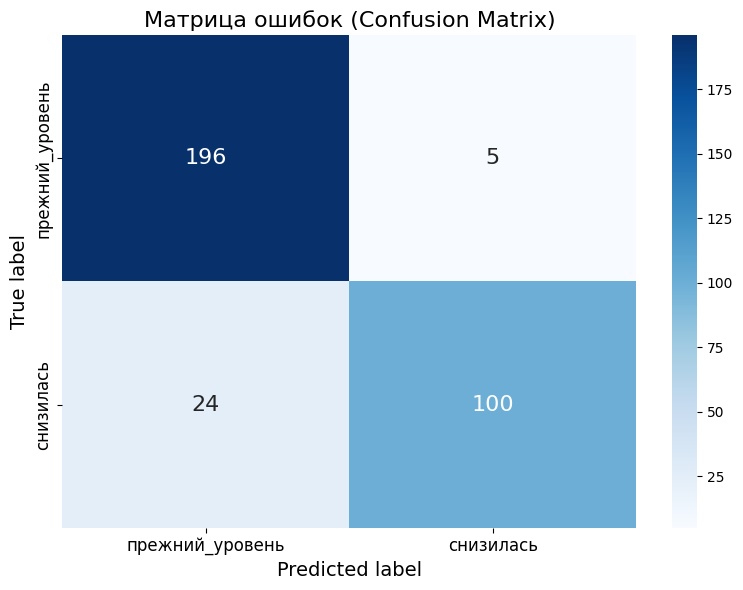

In [185]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar=True,
            xticklabels=['прежний_уровень', 'снизилась'],
            yticklabels=['прежний_уровень', 'снизилась'],
            annot_kws={'size': 16})

plt.title('Матрица ошибок (Confusion Matrix)', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

**Выводы по Шагу 6:**

Проделанная работа:

- Препроцессинг:

    - Применены 2 кодировщика (OneHotEncoder, OrdinalEncoder)
    - Использованы 2 скейлера (StandardScaler, MinMaxScaler)

- Подбор гиперпараметров:

    - Протестированы 4 модели с различными комбинациями параметров
    - Использована стратегия единого пайплайна с RandomizedSearchCV
    - Применена 5-кратная кросс-валидация

Результаты поиска лучшей модели:

- Лучшая модель: SVC (Support Vector Classifier)

- Параметры лучшей модели:
    - Алгоритм: SVC с ядром RBF
    - Регуляризация: C=0,1 (сильная регуляризация)
    
- Препроцессинг:
    - Категориальные признаки: OrdinalEncoder
    - Числовые признаки: StandardScaler
    
Оценка метрик:

- ROC-AUC на кросс-валидации: 0.9082
- ROC-AUC на тестовой выборке: 0.9255
- F1-Score на тесте: 0.8734

- ROC-AUC = 0.9255 - отличный результат:
    - Модель хорошо разделяет классы
    - Высокая способность отличать клиентов со снижением активности
    - Устойчивость к дисбалансу классов подтверждена
    
- F1-Score = 0.8734 - хороший баланс:
    - Учитывает как precision, так и recall
    - Подтверждает практическую применимость модели

- Матрица ошибок показывает:
    - True Negative (TN): 196 - правильно предсказаны клиенты с прежней активностью
    - False Positive (FP): 5 - ложно предсказано снижение активности (минимальные потери)
    - False Negative (FN): 24 - пропущены клиенты со снижением активности (критическая ошибка)
    - True Positive (TP): 100 - правильно выявлены клиенты со снижением активности

Таким образом, модель успешно прошла валидацию и готова для анализа важности признаков и сегментации клиентов на шагах 7-8.

# Шаг 7. Анализ важности признаков

7.1 Оценим важность признаков для лучшей модели 

- Permutation importance

Получаем лучшую модель из RandomizedSearchCV:

In [186]:
best_model = randomized_search.best_estimator_

Вычисляем permutation importance:

In [187]:
perm_importance = permutation_importance(
    best_model, X_test, y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Создаем DataFrame с важностью признаков:

In [188]:
perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print('Важность признаков по Permutation Importance:')
print(perm_importance_df.round(3))

Важность признаков по Permutation Importance:
                                feature  importance_mean  importance_std
10                     страниц_за_визит            0.026           0.006
13               минут_предыдущий_месяц            0.021           0.006
5                     акционные_покупки            0.015           0.003
7   средний_просмотр_категорий_за_визит            0.012           0.004
12          выручка_препредыдущий_месяц            0.006           0.004
2                    маркет_актив_6_мес            0.005           0.005
14                  минут_текущий_месяц            0.005           0.006
4                          длительность            0.003           0.001
6                  популярная_категория            0.003           0.003
8    неоплаченные_продукты_штук_квартал            0.002           0.003
3                  маркет_актив_тек_мес            0.001           0.001
0                           тип_сервиса            0.001           0.000
11   

Визуализация Permutation Importance:

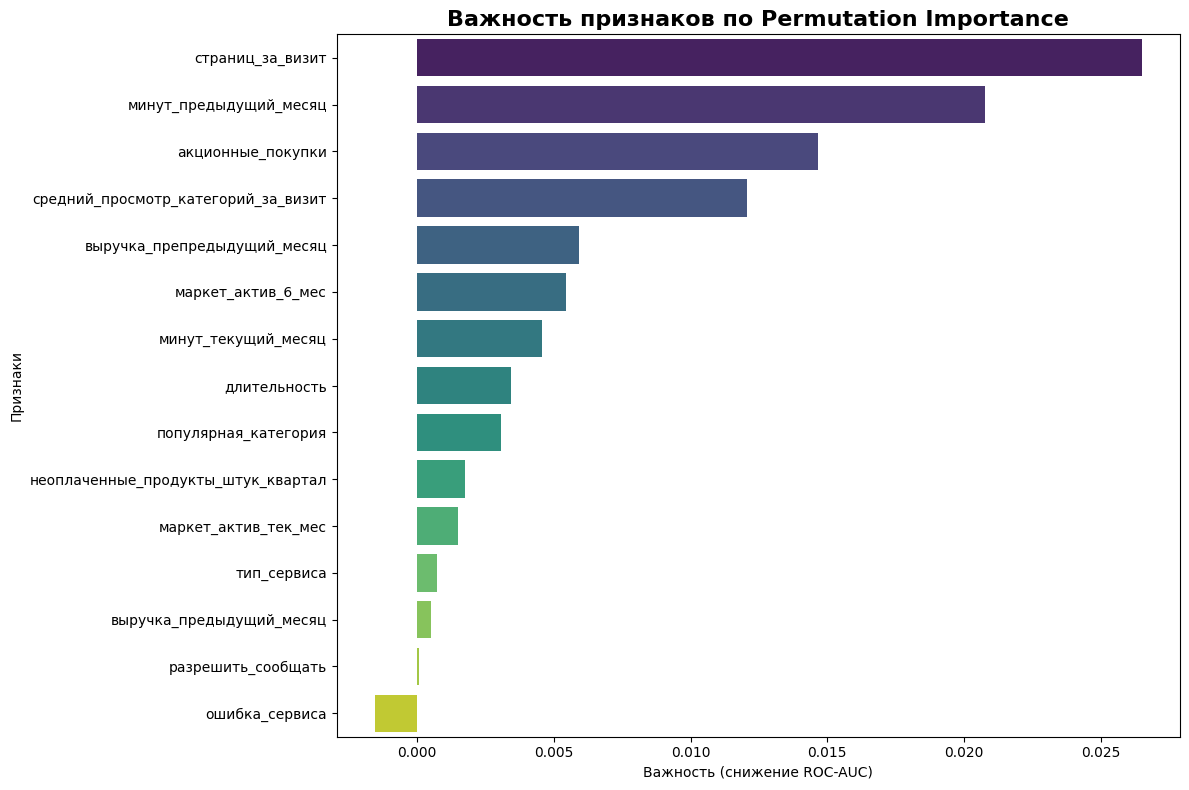

In [189]:
plt.figure(figsize=(12, 8))
top_features = perm_importance_df
sns.barplot(data=top_features, x='importance_mean', y='feature', 
            palette='viridis')
plt.title('Важность признаков по Permutation Importance', fontsize=16, fontweight='bold')
plt.xlabel('Важность (снижение ROC-AUC)')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

**Комментарий:**

С точки зрения Permutation Importance наиболее важные признаки:
- страниц_за_визит,
- минут_предыдущий_месяц,
- акционные_покупки,
- средний_просмотр_категорий_за_визит.

- SHAP

 Получаем компоненты лучшей модели:

In [190]:
final_model = best_model.named_steps['models']
best_preprocessor = best_model.named_steps['preprocessor']

In [191]:
final_model

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",np.float64(0.1)
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [192]:
best_preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat_ordinal', ...), ('num_standard', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``featu

Преобразуем тестовые данные с помощью препроцессора:

In [193]:
X_test_processed = best_preprocessor.transform(X_test)

Получаем имена признаков после препроцессинга:

In [194]:
feature_names = cat_columns + num_columns

print(f'Размерность обработанных данных: {X_test_processed.shape}')
print(f'Количество признаков: {len(feature_names)}')

Размерность обработанных данных: (325, 15)
Количество признаков: 15


Вычисление SHAP значений. Для SVC модели используем KernelExplainer:

In [195]:
explainer = shap.KernelExplainer(final_model.predict_proba, X_test_processed[:100])
shap_values = explainer.shap_values(X_test_processed, nsamples=100)

100%|█████████████████████████████████████████| 325/325 [00:51<00:00,  6.27it/s]


Для бинарной классификации берем SHAP значения для положительного класса (снизилась):

In [196]:
shap_values_positive = shap_values[:, :, 1]
print(f'Размерность SHAP значений: {shap_values_positive.shape}')

Размерность SHAP значений: (325, 15)


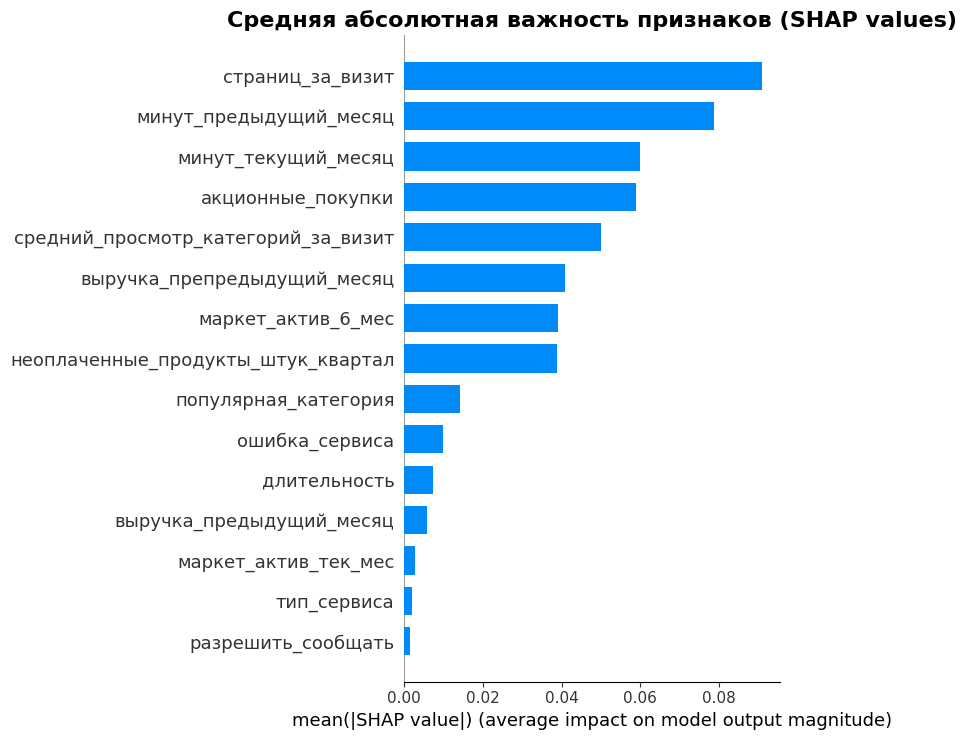

In [197]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_processed, 
                  feature_names=feature_names, plot_type='bar', show=False)
plt.title('Средняя абсолютная важность признаков (SHAP values)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Комментарий:**

С точки зрения SHAP значений наиболее важные признаки:
- страниц_за_визит,
- минут_предыдущий_месяц,
- минут_текущий_месяц (более высокая важность, в сравнении с Permutation Importance),
- акционные_покупки,
- средний_просмотр_категорий_за_визит,
- выручка_предыдущий_месяц,
- маркет_актив_6_мес,
- неоплаченные_продукты_штук_квартал.

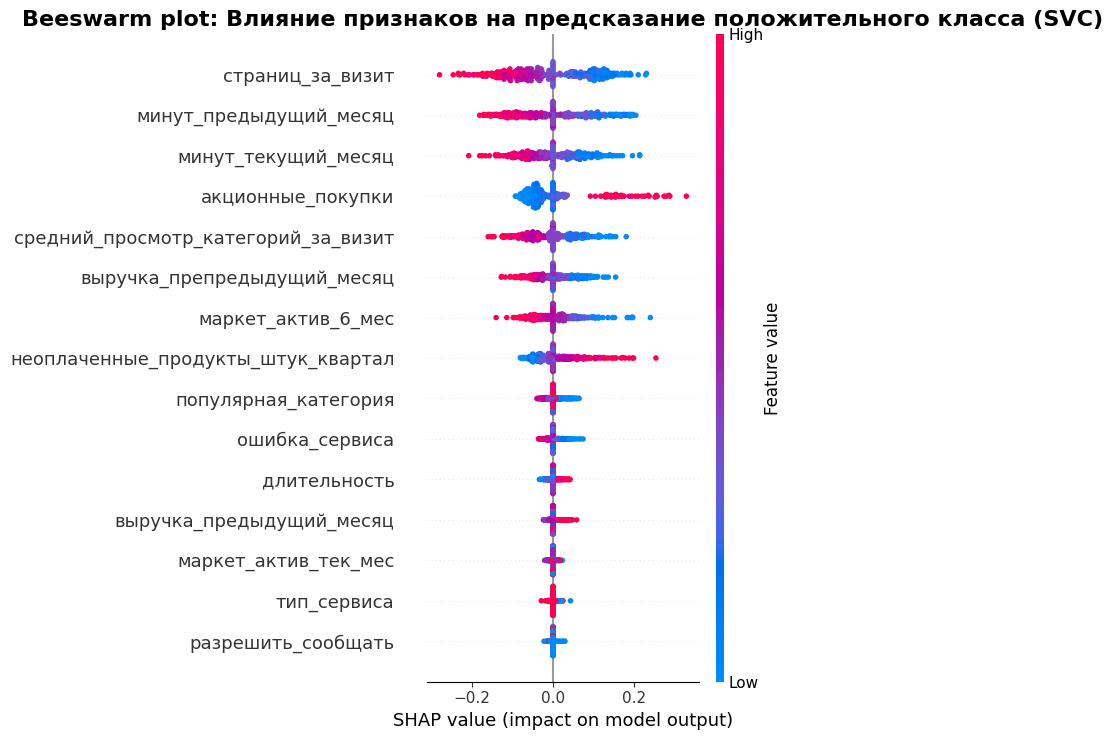

In [198]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_processed, 
                  feature_names=feature_names, 
                  plot_type='dot',  # beeswarm plot
                  show=False,
                  max_display=15)  # показываем все 15 признаков

plt.title('Beeswarm plot: Влияние признаков на предсказание положительного класса (SVC)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Комментарий:**

Анализ beeswarm plot показывает детальную картину влияния признаков на прогноз снижения покупательской активности:

Протективные факторы (снижают риск):
- Высокая активность (много страниц, много времени)
- Стабильное использование сервиса
- Историческая лояльность (маркет_актив_6_мес)

Факторы риска (повышают вероятность снижения):

- Резкое падение активности (мало страниц за визит)
- Сокращение времени использования
- Низкая вовлеченность в просмотр категорий

Комплексные паттерны:

- Акционные покупки - могут быть индикатором "случайных" покупателей
- Неоплаченные продукты - может указывать на проблемы или на активное тестирование


**Выводы по Шагу 7:**

Признаки, сильнее всего влияющие на целевой признак:

Топ-5 наиболее важных признаков (согласно обоим методам):

- страниц_за_визит - самый важный признак
    - Permutation Importance: 0.026
    - Сильное протективное влияние (высокие значения снижают риск)

- минут_предыдущий_месяц - второй по важности
    - Permutation Importance: 0.021
    - Ключевой показатель вовлеченности

- акционные_покупки - фактор риска
    - Permutation Importance: 0.015
    - Высокие значения УВЕЛИЧИВАЮТ вероятность снижения активности

- средний_просмотр_категорий_за_визит

    - Permutation Importance: 0.012
    - Показатель широты интересов клиента

- минут_текущий_месяц (высокая важность в SHAP)
    - Показатель текущей вовлеченности

Признаки с низкой значимостью для модели:

- разрешить_сообщать (0.000) - согласие на рассылку не влияет на активность
- ошибка_сервиса (-0,002) - технические сбои минимально влияют на поведение
- выручка_предыдущий_месяц (0,001) - краткосрочная выручка менее показательна
- тип_сервиса (0,001) - тип подписки слабо коррелирует со снижением активности
- маркет_актив_тек_мес (0,001) - текущая маркетинговая активность незначима

Поведенческие паттерны успешных клиентов:

- Активное использование сайта (много страниц, много времени) = низкий риск ухода
- Широкие интересы (просмотр многих категорий) = стабильная лояльность
- Историческая стабильность = надежность клиента

Тревожные сигналы:

- Высокая доля акционных покупок = риск потери клиента после акций
- Резкое снижение активности = предвестник ухода
- Узкие интересы = меньшая привязанность к магазину

Рекомендации для моделирования:

Оптимизация модели:

- Сфокусироваться на ключевых признаках:
    - Поведенческие метрики (активность на сайте)
    - Исторические паттерны покупок
    - Показатели вовлеченности

- Упростить модель:
    - Исключить маловажные признаки: разрешить_сообщать, ошибка_сервиса

Рекомендации для бизнес-решений:

1. Система раннего предупреждения:

- Мониторинг снижения активности по ключевым метрикам
- Автоматические уведомления при падении показателей ниже порогов

2. Персонализированные интервенции:
- Для клиентов с высокой долей акционных покупок: программы лояльности
- Для снижающих активность: персональные предложения, бонусы
- Для активных клиентов: премиум-контент, эксклюзивные предложения

3. Оптимизация клиентского опыта:
- Улучшение навигации (увеличивает страниц_за_визит)
- Развитие рекомендательной системы (увеличивает средний_просмотр_категорий)
- Стимулирование регулярного взаимодействия

4. Маркетинговая стратегия:
- Сбалансировать акционные кампании - избегать привлечения "акционных охотников"
- Фокусироваться на качестве взаимодействия, а не количестве коммуникаций
- Разработать сегментацию на основе поведенческих паттернов

Ключевой вывод:

Поведение клиентов на сайте является наилучшим предиктором их будущей лояльности. Активные, вовлеченные клиенты с разнообразными интересами демонстрируют значительно более стабильное поведение, чем те, кто фокусируется только на акционных предложениях или демонстрирует снижение взаимодействия с платформой.

# Шаг 8. Сегментация покупателей

8.1 Сегментация покупателей на основе моделирования и прибыльности

Добавляем предсказанные вероятности и прибыльность к данным:

In [199]:
data_with_predictions = data_clear.copy()

In [200]:
data_with_predictions.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,8,11
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,10,10


In [201]:
data_with_predictions['вероятность_снижения'] = randomized_search.predict_proba(X)[:, 1]

In [202]:
money = money.set_index('id')

In [203]:
data_with_predictions = data_with_predictions.join(money, how='left')

In [204]:
data_with_predictions.info()

<class 'pandas.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   str    
 1   тип_сервиса                          1297 non-null   str    
 2   разрешить_сообщать                   1297 non-null   str    
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   str    
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит                     12

**Комментарий:** Данные объединили, пропуски отсутствуют.

8.2 Анализ выбранного сегмента - **Клиенты с максимальной долей покупок по акции и высокой вероятностью снижения активности**

Определяем пороги для сегмента:

In [205]:
акционные_порог = data_with_predictions['акционные_покупки'].quantile(0.75)  # Верхние 25%
вероятность_порог = data_with_predictions['вероятность_снижения'].quantile(0.75)  # Верхние 25%

print(f'Порог доли акционных покупок: {акционные_порог:.3f}')
print(f'Порог вероятности снижения: {вероятность_порог:.3f}')

Порог доли акционных покупок: 0.300
Порог вероятности снижения: 0.857


Выделяем целевой сегмент:

In [206]:
target_segment = data_with_predictions[
    (data_with_predictions['акционные_покупки'] >= акционные_порог) & 
    (data_with_predictions['вероятность_снижения'] >= вероятность_порог)
]

print(f'Размер целевого сегмента: {len(target_segment)} клиентов')
print(f'Доля от общей базы: {len(target_segment)/len(data_with_predictions)*100:.1f}%')

Размер целевого сегмента: 228 клиентов
Доля от общей базы: 17.6%


Выделим базу без целевого сегмента:

In [207]:
comparison_segment = data_with_predictions[
    ~data_with_predictions.index.isin(target_segment.index)
]

print(f'Размер базы без целевого сегмента: {len(comparison_segment)} клиентов')
print(f'Доля от общей базы: {len(comparison_segment)/len(data_with_predictions)*100:.1f}%')

Размер базы без целевого сегмента: 1069 клиентов
Доля от общей базы: 82.4%


Сравним статистику:

In [208]:
data_with_predictions.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_снижения,прибыль
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,4948.339630,4836.367772,13.469545,13.211257,0.382052,3.997610
std,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,701.228571,333.438742,3.936323,4.220222,0.380304,1.010813
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,5.000000,4.000000,0.009621,0.860000
25%,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.500000,4585.000000,11.000000,10.000000,0.065788,3.300000
50%,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4812.000000,13.000000,13.000000,0.166835,4.040000
75%,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5409.000000,5055.000000,17.000000,16.000000,0.856908,4.670000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,23.000000,23.000000,0.996203,7.430000


In [209]:
key_metrics = ['акционные_покупки', 'вероятность_снижения', 'прибыль', 'страниц_за_визит', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц', 'средний_просмотр_категорий_за_визит',
               'выручка_предыдущий_месяц','маркет_актив_6_мес', 'неоплаченные_продукты_штук_квартал', 
               'длительность']

comparison_stats = {}
for metric in key_metrics:
    comparison_stats[metric] = {
        'Весь_датасет_среднее': data_with_predictions[metric].mean(),
        'Весь_датасет_std': data_with_predictions[metric].std(),
        'Целевой_сегмент_среднее': target_segment[metric].mean(),
        'Целевой_сегмент_std': target_segment[metric].std(),
        'Остальные_среднее': comparison_segment[metric].mean(),
        'Остальные_std': comparison_segment[metric].std()
    }

In [210]:
comparison_df = pd.DataFrame(comparison_stats).T
print('Сравнительная статистика ключевых показателей:')
display(comparison_df[['Весь_датасет_среднее', 'Целевой_сегмент_среднее', 'Остальные_среднее']].round(3))

Сравнительная статистика ключевых показателей:


,Весь_датасет_среднее,Целевой_сегмент_среднее,Остальные_среднее
акционные_покупки,0.321,0.650,0.250
вероятность_снижения,0.382,0.961,0.258
прибыль,3.998,3.936,4.011
страниц_за_визит,8.187,3.982,9.083
минут_предыдущий_месяц,13.470,9.553,14.305
минут_текущий_месяц,13.211,9.978,13.901
средний_просмотр_категорий_за_визит,3.268,2.408,3.451
выручка_предыдущий_месяц,4948.340,4987.296,4940.031
маркет_актив_6_мес,4.254,3.433,4.430
неоплаченные_продукты_штук_квартал,2.841,4.167,2.558


Создаем подграфики:

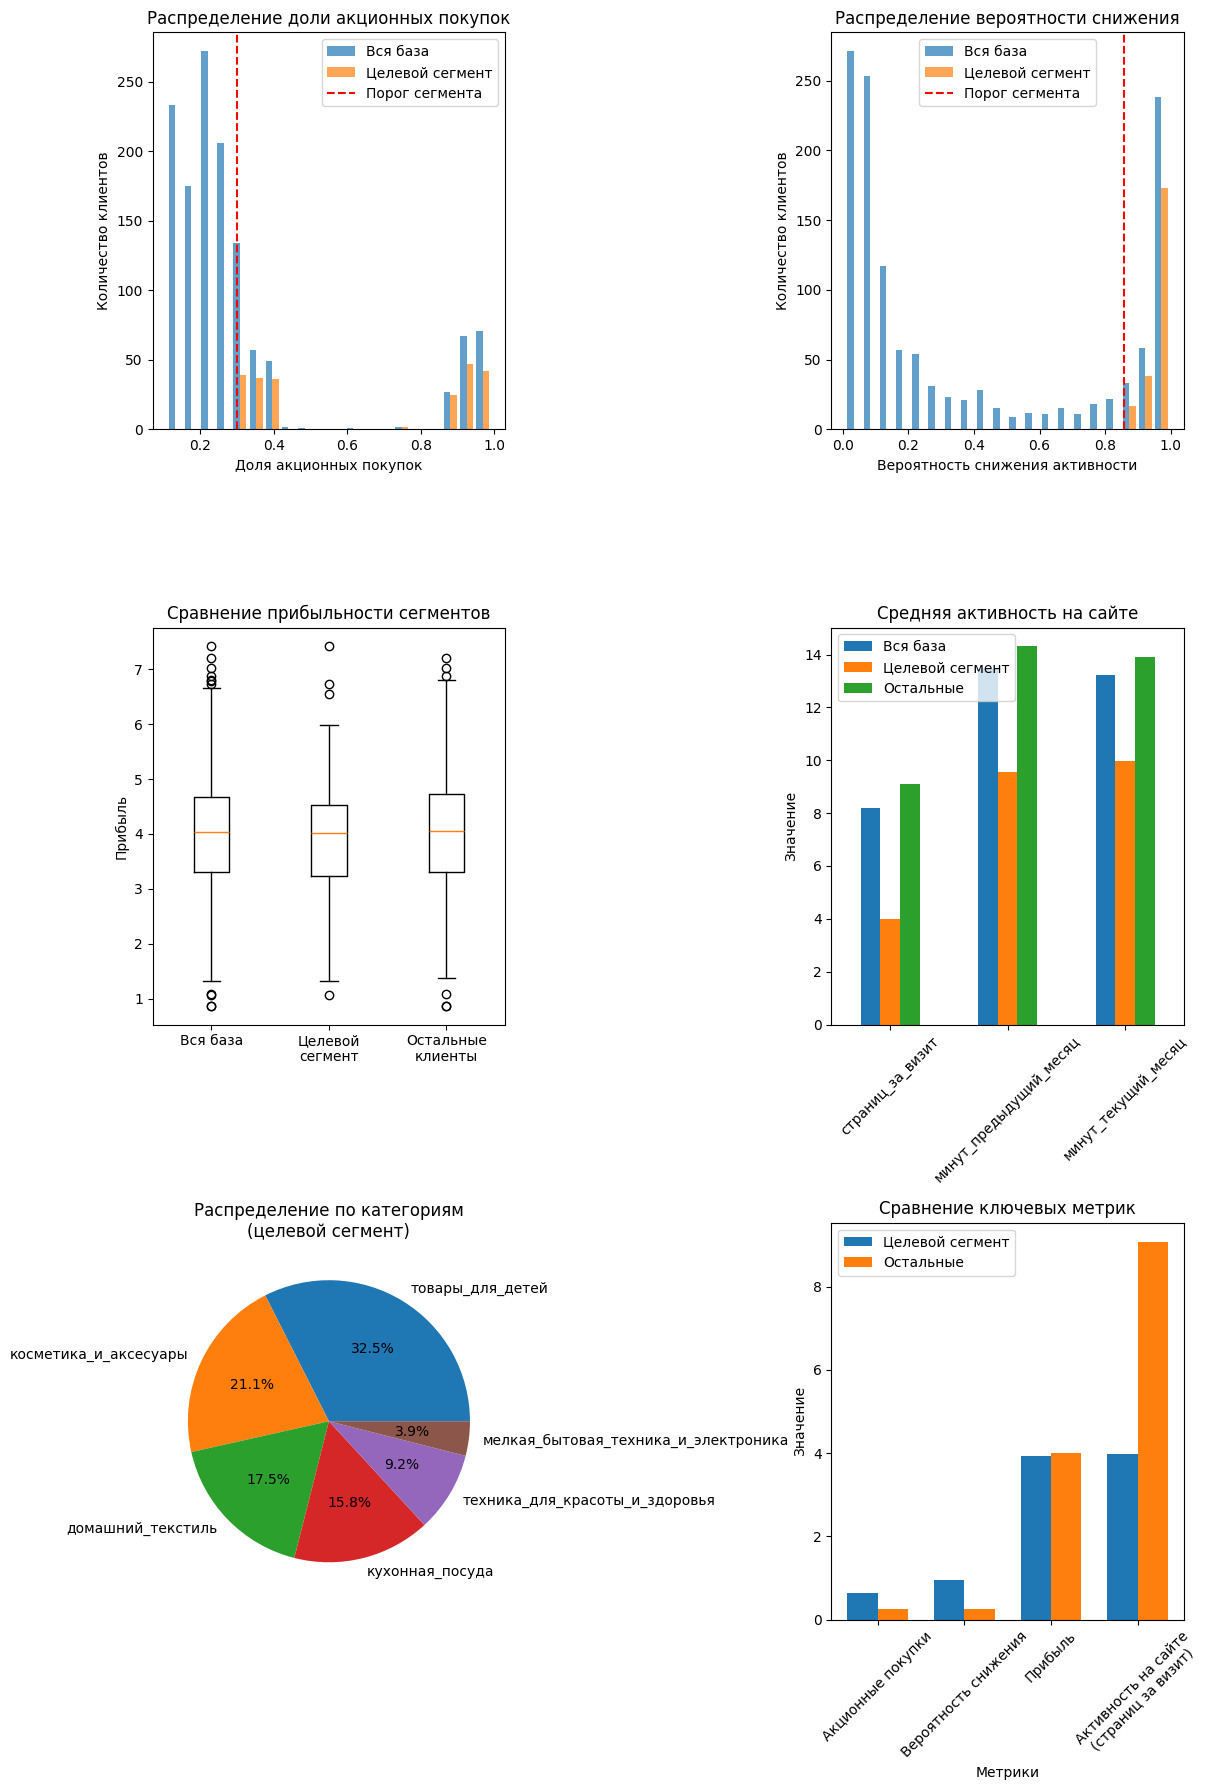

In [211]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))


# График 1: Распределение доли акционных покупок
axes[0,0].hist([data_with_predictions['акционные_покупки'], target_segment['акционные_покупки']], 
               bins=20, alpha=0.7, label=['Вся база', 'Целевой сегмент'])
axes[0,0].axvline(акционные_порог, color='red', linestyle='--', label='Порог сегмента')
axes[0,0].set_xlabel('Доля акционных покупок')
axes[0,0].set_ylabel('Количество клиентов')
axes[0,0].set_title('Распределение доли акционных покупок')
axes[0,0].legend()

# График 2: Распределение вероятности снижения
axes[0,1].hist([data_with_predictions['вероятность_снижения'], target_segment['вероятность_снижения']], 
               bins=20, alpha=0.7, label=['Вся база', 'Целевой сегмент'])
axes[0,1].axvline(вероятность_порог, color='red', linestyle='--', label='Порог сегмента')
axes[0,1].set_xlabel('Вероятность снижения активности')
axes[0,1].set_ylabel('Количество клиентов')
axes[0,1].set_title('Распределение вероятности снижения')
axes[0,1].legend()

# График 3: Прибыльность сегментов
profit_data = [data_with_predictions['прибыль'], target_segment['прибыль'], comparison_segment['прибыль']]
axes[1,0].boxplot(profit_data, labels=['Вся база', 'Целевой\nсегмент', 'Остальные\nклиенты'])
axes[1,0].set_ylabel('Прибыль')
axes[1,0].set_title('Сравнение прибыльности сегментов')

# График 4: Активность на сайте
activity_metrics = ['страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
activity_data = []
for metric in activity_metrics:
    activity_data.append([
        data_with_predictions[metric].mean(),
        target_segment[metric].mean(),
        comparison_segment[metric].mean()
    ])

activity_df = pd.DataFrame(activity_data, index=activity_metrics, 
                          columns=['Вся база', 'Целевой сегмент', 'Остальные'])
activity_df.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Средняя активность на сайте')
axes[1,1].set_ylabel('Значение')
axes[1,1].tick_params(axis='x', rotation=45)

# График 5: Распределение по популярным категориям
category_dist = target_segment['популярная_категория'].value_counts()
axes[2,0].pie(category_dist.values, labels=category_dist.index, autopct='%1.1f%%')
axes[2,0].set_title('Распределение по категориям\n(целевой сегмент)')

# График 6: Сравнение ключевых метрик
key_comparison_data = {
    'Акционные покупки': [target_segment['акционные_покупки'].mean(), comparison_segment['акционные_покупки'].mean()],
    'Вероятность снижения': [target_segment['вероятность_снижения'].mean(), comparison_segment['вероятность_снижения'].mean()],
    'Прибыль': [target_segment['прибыль'].mean(), comparison_segment['прибыль'].mean()],
    'Активность на сайте\n(страниц за визит)': [target_segment['страниц_за_визит'].mean(), comparison_segment['страниц_за_визит'].mean()
    ]
}

key_comparison_df = pd.DataFrame(key_comparison_data, index=['Целевой сегмент', 'Остальные']).T

x = np.arange(len(key_comparison_df))
width = 0.35
axes[2,1].bar(x - width/2, key_comparison_df['Целевой сегмент'], width, label='Целевой сегмент')
axes[2,1].bar(x + width/2, key_comparison_df['Остальные'], width, label='Остальные')
axes[2,1].set_xlabel('Метрики')
axes[2,1].set_ylabel('Значение')
axes[2,1].set_title('Сравнение ключевых метрик')
axes[2,1].set_xticks(x)
axes[2,1].set_xticklabels(key_comparison_df.index, rotation=45)
axes[2,1].legend()

plt.tight_layout()
plt.show()

Характеристики сегмента:

In [212]:
print(f"Высокая зависимость от акций (в среднем {target_segment['акционные_покупки'].mean():.1%} покупок по акции)")

Высокая зависимость от акций (в среднем 65.0% покупок по акции)


In [213]:
print(f"Высокий риск ухода ({target_segment['вероятность_снижения'].mean():.1%} вероятность снижения)")


Высокий риск ухода (96.1% вероятность снижения)


In [214]:
print(f"Средняя прибыль целевого сегмента: {target_segment['прибыль'].mean():.3f}")
print(f"Средняя прибыль остальных клиентов: {comparison_segment['прибыль'].mean():.3f}")
print(f"Разница: {(target_segment['прибыль'].mean() - comparison_segment['прибыль'].mean()):.3f}")

Средняя прибыль целевого сегмента: 3.936
Средняя прибыль остальных клиентов: 4.011
Разница: -0.075


In [215]:
print(f"Средняя активность на сайте (страниц/визит):")
print(f"  - Целевой сегмент: {target_segment['страниц_за_визит'].mean():.1f}")
print(f"  - Остальные: {comparison_segment['страниц_за_визит'].mean():.1f}")

print(f"\nСреднее время на сайте (минут):")
print(f"  - Целевой сегмент: {target_segment['минут_предыдущий_месяц'].mean():.1f}")
print(f"  - Остальные: {comparison_segment['минут_предыдущий_месяц'].mean():.1f}")


Средняя активность на сайте (страниц/визит):
  - Целевой сегмент: 4.0
  - Остальные: 9.1

Среднее время на сайте (минут):
  - Целевой сегмент: 9.6
  - Остальные: 14.3


In [216]:
print(f"Низкая вовлеченность на сайте (на {((comparison_segment['страниц_за_визит'].mean() - target_segment['страниц_за_визит'].mean())/comparison_segment['страниц_за_визит'].mean()*100):.0f}% меньше страниц)")

Низкая вовлеченность на сайте (на 56% меньше страниц)


In [217]:
print("Топ-3 категории в целевом сегменте:")
top_categories = target_segment['популярная_категория'].value_counts().head(3)
for i, (category, count) in enumerate(top_categories.items(), 1):
    print(f"{i}. {category}: {count} клиентов ({count/len(target_segment)*100:.1f}%)")

Топ-3 категории в целевом сегменте:
1. товары_для_детей: 74 клиентов (32.5%)
2. косметика_и_аксесуары: 48 клиентов (21.1%)
3. домашний_текстиль: 40 клиентов (17.5%)


Анализ типа сервиса:

In [218]:
print(f"Распределение по типу сервиса:")
service_dist = target_segment['тип_сервиса'].value_counts()
for service, count in service_dist.items():
    print(f"- {service}: {count} клиентов ({count/len(target_segment)*100:.1f}%)")

Распределение по типу сервиса:
- стандарт: 144 клиентов (63.2%)
- премиум: 84 клиентов (36.8%)


Анализ разрешения на коммуникации:

In [219]:
comms_allowed = target_segment['разрешить_сообщать'].value_counts()
print(f"\nКлиенты, разрешившие коммуникации: {comms_allowed.get('да', 0)} ({comms_allowed.get('да', 0)/len(target_segment)*100:.1f}%)")


Клиенты, разрешившие коммуникации: 172 (75.4%)


**Выводы по Шагу 8:**

Выбранный сегмент: Клиенты с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Обоснование выбора:

- критический риск оттока - 96,1% вероятность снижения активности (самый высокий показатель среди всех клиентов);
- значительный размер сегмента - 228 клиентов (17,6% от всей базы), что представляет существенную ценность для бизнеса;
- поведенческая специфика - ярко выраженная зависимость от акционных предложений требует особого подхода;
- потенциал для улучшения - низкие показатели вовлеченности оставляют пространство для роста.

Результаты анализа сегмента

Ключевые характеристики целевого сегмента:

- Поведенческие особенности:
    - высокая акционная зависимость - 65% покупок совершаются по акциям (в 2,6 раза выше, чем у остальных клиентов);
    - крайне низкая вовлеченность - всего 4 страницы за визит (на 56% меньше, чем у остальных клиентов);
    - минимальное время на сайте - 9,6 минут в предыдущем месяце (на 33% меньше среднего).
    
- Финансовые показатели:
    - сниженная прибыльность - 3,9 усл. ед. (на 0.075 ниже, чем у остальных клиентов);
    - средняя выручка - 4987,3 усл. ед. (сопоставима с общей базой).

Доп. информация:
- преобладание стандартного сервиса - 63,2% клиентов;
- высокая доступность для коммуникаций - 75,4% разрешили рассылку;
- топ категории: товары для детей (32,5%), косметика (21,1%), домашний текстиль (17,5%).

Предложения по работе с сегментом:

Стратегия 1: Трансформация "акционных охотников" в лояльных клиентов

- Программа "Постоянный клиент":
    - внедрить накопительную систему бонусов за регулярные покупки вне акций;
    - персональные кэшбэки 5-7% для стимулирования неакционных покупок;
    - привилегированный статус с эксклюзивными условиями.

Стратегия 2: Повышение вовлеченности на сайте

- Персонализированный контент:
    - рекомендательные системы на основе предпочтений (особенно для категорий товаров для детей и косметики);
    - интерактивные подборки "Персональная подборка недели";
    - контент-маркетинг: обзоры товаров, руководства по использованию, советы экспертов.

Стратегия 3: Стимулирование регулярного взаимодействия

- Программа подписки:
    - "автозаказ" для регулярно покупаемых товаров со скидкой 10-15%;
    - напоминания о пополнении запасов с персональными предложениями;
    - система "Отложенных покупок" с постепенным накоплением скидки.

Стратегия 4: Целевые коммуникации

- Сегментированный маркетинг:
    - для клиентов с товарами для детей: программы "Растем вместе", рекомендации по возрастным группам;
    - для косметики: программы ухода, сезонные рекомендации, пробники новинок;
    - для домашнего текстиля: сезонные обновления, комплекты со скидкой.

**Ключевой вывод:**

Выбранный сегмент представляет стратегическую важность для бизнеса благодаря сочетанию высокого риска оттока и значительного потенциала для роста. Уникальная поведенческая характеристика - зависимость от акций - требует специализированного подхода, направленного на трансформацию паттернов покупок и построение устойчивой лояльности через персонализацию и программы постоянного клиента.

Инвестиции в удержание этой группы могут принести диспропорционально высокую отдачу за счет сохранения значительной клиентской базы и повышения их долгосрочной ценности.


# Шаг 9. Общий вывод

9.1 Описание задачи

Бизнес-задача: Разработка системы персонализированных предложений для удержания постоянных клиентов интернет-магазина "В один клик" и увеличения их покупательской активности.

ML-задача: Построение модели бинарной классификации для прогнозирования вероятности снижения покупательской активности клиентов в следующие три месяца.

Ключевая цель: Выделение сегментов клиентов с высоким риском снижения активности и разработка целевых стратегий для их удержания.

9.2 Исходные данные и предобработка

Источники данных:

- market_file.csv - основные характеристики (1300 клиентов, 13 признаков)
- market_money.csv - данные о выручке по трем временным периодам
- market_time.csv - данные о времени на сайте по двум периодам
- money.csv - информация о прибыльности клиентов

Проведенная предобработка:

Качество данных:

- Пропуски отсутствовали во всех таблицах
- Исправлены опечатки в категориальных значениях (стандартт → стандарт)
- Обработан экстремальный выброс в выручке (1 клиент с >100 000 заменен на медиану)
- Унифицированы форматы строковых данных (нижний регистр, snake_case)

Объединение и фильтрация:

- Объединены 3 таблицы в единый датасет (18 признаков)
- Выделены только активные клиенты (покупавшие во всех 3 месяцах) - 1297 клиентов
- Устранена мультиколлинеарность (исключен выручка_текущий_месяц)


9.3 Поиск лучшей модели

Методология:

- Стратегия: Единый пайплайн с RandomizedSearchCV
- Валидация: 5-кратная кросс-валидация
- Метрика: ROC-AUC (обоснована устойчивостью к дисбалансу и бизнес-требованиями)

Протестированные модели и гиперпараметры:

- KNeighborsClassifier - n_neighbors
- DecisionTreeClassifier - max_depth, max_features
- LogisticRegression - C
- SVC - C, kernel

Препроцессинг:
- Категориальные признаки: OneHotEncoder и OrdinalEncoder
- Числовые признаки: StandardScaler и MinMaxScaler
- Обработка пропусков: SimpleImputer

9.4 Лучшая модель:

- Алгоритм: SVC (Support Vector Classifier)

- Параметры:
    - Ядро: RBF
    - Регуляризация: C=0,1
    - Препроцессинг: OrdinalEncoder + StandardScaler

- Результаты:

    - ROC-AUC на кросс-валидации: 0,9082
    - ROC-AUC на тестовой выборке: 0,9255
    - F1-Score: 0,8734

- Интерпретируемость: Модель показала отличную способность разделять классы с учетом дисбаланса (38% снизилась vs 62% прежний уровень)

9.5 Анализ важности признаков

Ключевые предикторы снижения активности:

- страниц_за_визит - самый важный признак (протективный фактор)
- минут_предыдущий_месяц - показатель исторической вовлеченности
- акционные_покупки - фактор риска (высокие значения увеличивают вероятность снижения)
- средний_просмотр_категорий_за_визит - широта интересов клиента

Бизнес-инсайты:

- Активность на сайте - наилучший индикатор будущего поведения
- Клиенты с высокой долей акционных покупок представляют группу риска
- Исторические данные более показательны, чем текущие

9.6 Выбранный сегмент и рекомендации

Целевой сегмент:

Клиенты с максимальной долей покупок по акции (>75 перцентиль) и высокой вероятностью снижения активности (>75 перцентиль)

Характеристики сегмента (228 клиентов, 17,6% базы):

- Доля акционных покупок: 65% (в 2,6 раза выше среднего)
- Вероятность снижения: 96,1%
- Активность на сайте: 4,0 страниц/визит (на 56% ниже среднего)
- Прибыльность: 3,936 (ниже на 0,075 чем в среднем)

Стратегия удержания:

1. Программа лояльности для "акционных охотников"

- Накопительная система бонусов за неакционные покупки
- Персональные кэшбэки 5-7% для регулярных клиентов
- Привилегированный статус с эксклюзивными условиями

2. Персонализация взаимодействия

- Рекомендательные системы для категорий-лидеров (товары для детей 32,5%, косметика 21,1%)
- Интерактивные подборки "Персональная подборка недели"
- Контент-маркетинг: обзоры, руководства, советы экспертов

3. Стимулирование регулярности

- Программа подписки "Автозаказ" со скидкой 10-15%
- Система напоминаний о пополнении запасов
- "Отложенные покупки" с накопительной скидкой

Дополнительные предложения

Для бизнеса:

- Внедрить систему мониторинга ключевых поведенческих метрик
- Разработать автоматические уведомления при снижении активности клиентов
- Интегрировать модель прогнозирования в CRM-систему

Для дальнейшего развития:

- Собирать дополнительные данные о причинах снижения активности
- Исследовать сезонные паттерны покупательского поведения

**Итог:**

Проект успешно решил поставленную задачу: построена высококачественная модель прогнозирования снижения покупательской активности (ROC-AUC 0,9255) и выделен стратегически важный сегмент клиентов для целевого удержания. Разработанные рекомендации позволяют бизнесу проактивно работать с клиентами группы риска, повышая их лояльность и увеличивая пожизненную ценность.

Ключевой успех: Модель не только показывает высокие метрики, но и предоставляет интерпретируемые инсайты для принятия бизнес-решений, фокусируясь на наиболее значимых поведенческих паттернах клиентов.